**Multi Horizon IMU Prediction**


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import os


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import numpy as np
import pandas as pd


# 1) Load data
def load_imu_csv(csv_file_path, tags=('acc', 'gyro')):
    df = pd.read_csv(csv_file_path, low_memory=False)
    df = df[df['tag'].isin(tags)].copy()
    df['timestamp'] = pd.to_numeric(df['timestamp'], errors='coerce')
    for c in ('x', 'y', 'z'):
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df.dropna(subset=['timestamp', 'x', 'y', 'z'], inplace=True)
    return df


# 2) Read F3 (cell row 3, col F) calibration JSON
def read_calibration_from_f3(csv_file_path):
    head = pd.read_csv(csv_file_path, header=None, nrows=3, dtype=str, engine="python")
    f3_raw = head.iat[2, 5]  # F3
    try:
        calib = json.loads(f3_raw)
    except json.JSONDecodeError as e:
        raise ValueError(f"Failed to parse JSON from cell F3: {e}\nValue in F3 was:\n{f3_raw}")

    # Defaults + reshaping
    b_gyro = np.array(calib.get('b_gyro1', [0, 0, 0]), dtype=float)
    Sgyro  = np.array(calib.get('Sgyro1',  [1,0,0,0,1,0,0,0,1]), dtype=float).reshape(3,3)

    b_acc = np.array(calib.get('b_acc1', [0, 0, 0]), dtype=float)
    Sacc  = np.array(calib.get('Sacc1',  [1,0,0,0,1,0,0,0,1]), dtype=float).reshape(3,3)

    return {
        'b_gyro': b_gyro, 'Sgyro': Sgyro,
        'b_acc': b_acc,   'Sacc': Sacc,
        'have_acc_cal': ('b_acc1' in calib) and ('Sacc1' in calib)
    }


# 3) Calibrate per tag
def apply_calibration(df: pd.DataFrame, cal: dict) -> pd.DataFrame:
    df = df.copy().reset_index(drop=True)  # ensure positional indexing
    # ensure float dtype for x,y,z
    df[['x','y','z']] = df[['x','y','z']].apply(pd.to_numeric, errors='coerce').astype('float64')

    # columns positions for iloc
    xyz_cols = [df.columns.get_loc(c) for c in ('x','y','z')]

    # calibration arrays
    b_gyro = np.asarray(cal['b_gyro'], dtype=float).reshape(3)
    Sgyro  = np.asarray(cal['Sgyro'],  dtype=float).reshape(3,3)

    have_acc = cal.get('have_acc_cal', ('b_acc' in cal and 'Sacc' in cal))
    if have_acc:
        b_acc = np.asarray(cal['b_acc'], dtype=float).reshape(3)
        Sacc  = np.asarray(cal['Sacc'],  dtype=float).reshape(3,3)

    # indices by tag (positional)
    tags = df['tag'].to_numpy()
    gyro_idx = np.flatnonzero(tags == 'gyro')
    acc_idx  = np.flatnonzero(tags == 'acc')

    # gyro calibration
    if gyro_idx.size:
        gvals = df.iloc[gyro_idx, xyz_cols].to_numpy(dtype=float)
        gcal  = (gvals - b_gyro) @ Sgyro.T
        df.iloc[gyro_idx, xyz_cols] = gcal

    # acc calibration
    if have_acc and acc_idx.size:
        avals = df.iloc[acc_idx, xyz_cols].to_numpy(dtype=float)
        acal  = (avals - b_acc) @ Sacc.T
        df.iloc[acc_idx, xyz_cols] = acal

    return df


# 4) Split each tag by a timestamp gap
def split_by_gap_timestamp(df: pd.DataFrame, gap_us=35_000, min_len=1):
    """
    Split by gaps in numeric 'timestamp' (µs). Returns list of DataFrames.
    """
    ts = pd.to_numeric(df['timestamp'], errors='coerce')
    order = np.argsort(ts.values)
    df = df.iloc[order].reset_index(drop=True)
    ts = ts.iloc[order].reset_index(drop=True)

    gaps = ts.diff().to_numpy()
    cuts = np.ones(len(df), dtype=bool)
    cuts[1:] = (gaps[1:] > gap_us)

    segs, start = [], 0
    for i in range(len(df)):
        if cuts[i] and i != start:
            seg = df.iloc[start:i]
            if len(seg) >= min_len: segs.append(seg)
            start = i
    if start < len(df):
        seg = df.iloc[start:]
        if len(seg) >= min_len: segs.append(seg)
    return segs


# Orchestrator
def segment_by_tag(csv_file_path, gap_threshold_us=35_000, min_len=1):
    df_raw = load_imu_csv(csv_file_path, tags=('acc','gyro'))
    cal    = read_calibration_from_f3(csv_file_path)
    df_cal = apply_calibration(df_raw, cal)

    segments = split_by_gap_timestamp(df_cal, gap_us=gap_threshold_us, min_len=min_len)

    total_samples = len(df_cal)
    print(f"Found {total_samples} samples total")

    for i, seg in enumerate(segments, start=1):
        start_idx = seg.index[0]
        end_idx   = seg.index[-1]
        start_ts  = seg['timestamp'].iloc[0]
        end_ts    = seg['timestamp'].iloc[-1]

        print(f"Segment {i}: {len(seg)} samples  "
              f"[{start_idx} → {end_idx}]  "
              f"ts_range=[{start_ts}, {end_ts}]")

    return segments





In [4]:
CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/epsilon_52Hz/MayaRec1.csv"
segments = segment_by_tag(CSV_PATH, gap_threshold_us=40000, min_len=1)

Found 19942 samples total
Segment 1: 14940 samples  [0 → 14939]  ts_range=[933254608.0, 1073642456.0]
Segment 2: 1296 samples  [14940 → 16235]  ts_range=[1286973327.0, 1299123260.0]
Segment 3: 3706 samples  [16236 → 19941]  ts_range=[2468627258.0, 2503463165.0]


Found 19942 samples total
Segment 1: 14940 samples  [0 → 14939]  ts_range=[933254608.0, 1073642456.0]
Segment 2: 1296 samples  [14940 → 16235]  ts_range=[1286973327.0, 1299123260.0]
Segment 3: 3706 samples  [16236 → 19941]  ts_range=[2468627258.0, 2503463165.0]
Segment 1 chosen | imu rows: 7470 | Random sections: [(4545, 4745), (4974, 5174), (6870, 7070)]


/tmp/ipython-input-327042730.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


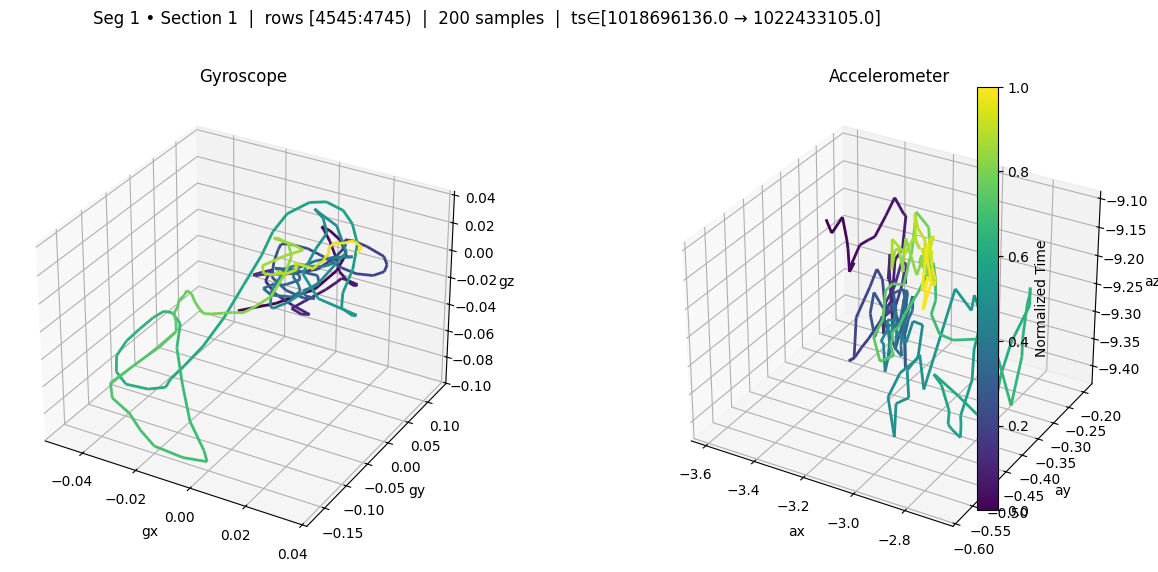

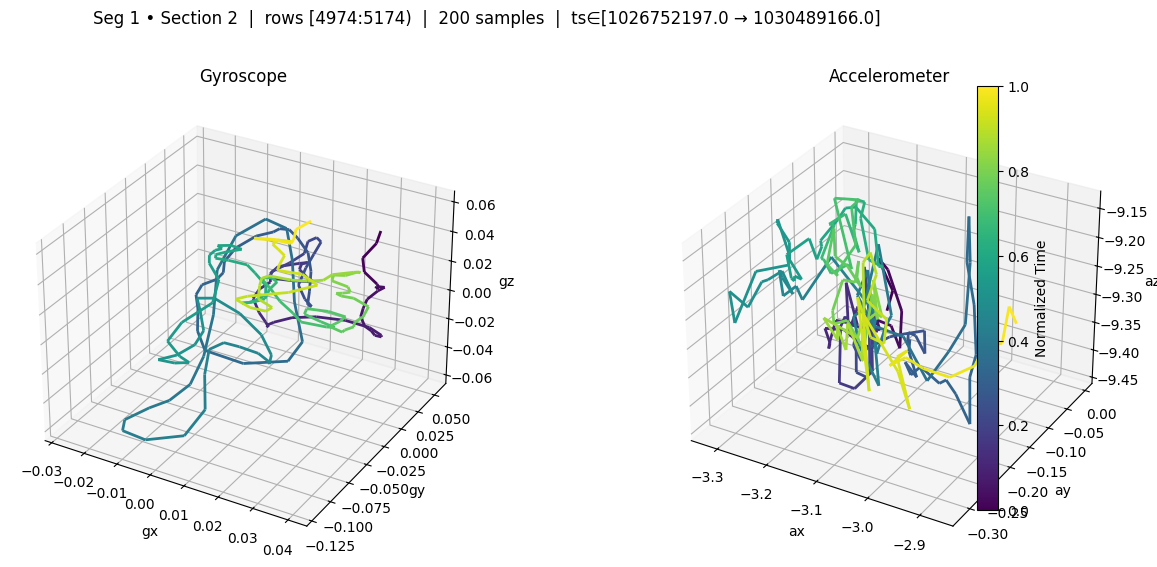

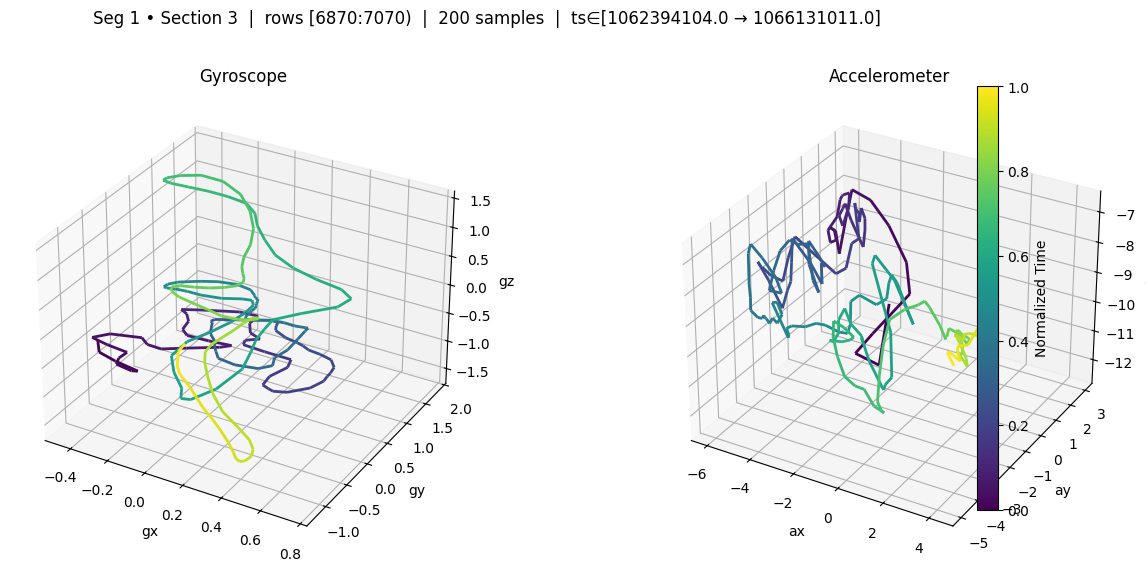

In [5]:
# --- Random 3×200-sample sanity plots using segment_by_tag ---

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/epsilon_52Hz/MayaRec1.csv"  # <-- set path
WINDOW = 200
N_SECTIONS = 3
SEED = 7
GAP_US = 40_000   # 35 ms tolerance between rows when splitting segments
MERGE_TOL_US = 1000  # acc↔gyro merge tolerance (1 ms)

# 1) Load + split into contiguous segments (your new function)
segs = segment_by_tag(CSV_PATH, gap_threshold_us=GAP_US, min_len=WINDOW*2)  # keep only reasonable-length segments

# 2) Helper: merge one segment's acc/gyro rows into a single IMU table
import pandas as pd
def segment_to_imu(seg_df, merge_tol_us=MERGE_TOL_US):
    seg_df = seg_df.sort_values('timestamp').reset_index(drop=True)

    # carry systemTime if present on acc side
    acc_cols = ['timestamp','x','y','z']
    if 'systemTime' in seg_df.columns:
        acc_cols = ['timestamp','systemTime','x','y','z']

    acc = seg_df[seg_df['tag']=='acc'][acc_cols].rename(
        columns={'x':'acc_x','y':'acc_y','z':'acc_z'}
    )
    gyr = seg_df[seg_df['tag']=='gyro'][['timestamp','x','y','z']].rename(
        columns={'x':'gyro_x','y':'gyro_y','z':'gyro_z'}
    )

    imu = pd.merge_asof(
        acc.sort_values('timestamp'),
        gyr.sort_values('timestamp'),
        on='timestamp',
        direction='nearest',
        tolerance=merge_tol_us
    ).dropna().reset_index(drop=True)

    return imu  # has gyro_x/y/z; systemTime only if it existed on acc rows

# choose a segment (largest by length)
seg_idx = int(np.argmax([len(s) for s in segs]))
imu = segment_to_imu(segs[seg_idx], MERGE_TOL_US)

def take_random_windows_no_overlap(N, window, n, seed=0):
    if N < window * n:
        raise ValueError(f"Recording too short ({N}) for {n}×{window} windows.")
    rng = np.random.default_rng(seed)
    starts, taken = [], np.zeros(N, dtype=bool)
    while len(starts) < n:
        s = int(rng.integers(0, N - window + 1))
        if not taken[s:s+window].any():
            starts.append(s)
            taken[s:s+window] = True
    starts.sort()
    return [(s, s+window) for s in starts]

def _time_norm(ts):
    ts = np.asarray(ts, dtype=float)
    tmin, tmax = float(np.min(ts)), float(np.max(ts))
    d = (tmax - tmin) or 1.0
    return (ts - tmin) / d

def _make_lc(x, y, z, tnorm):
    pts = np.column_stack([x, y, z]).reshape(-1, 1, 3)
    segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
    lc = Line3DCollection(segs, cmap=plt.colormaps['viridis'], norm=plt.Normalize(0, 1))
    lc.set_array(np.asarray(tnorm))
    lc.set_linewidth(2.0)
    return lc

def plot_gyro_acc_3d_section(df, s, e, title):
    seg = df.iloc[s:e]
    tnorm = _time_norm(seg['timestamp'])

    fig = plt.figure(figsize=(13, 5.5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    lc_g = _make_lc(seg['gyro_x'], seg['gyro_y'], seg['gyro_z'], tnorm)
    ax1.add_collection3d(lc_g)
    ax1.set_title("Gyroscope"); ax1.set_xlabel('gx'); ax1.set_ylabel('gy'); ax1.set_zlabel('gz')
    ax1.auto_scale_xyz(seg['gyro_x'], seg['gyro_y'], seg['gyro_z'])

    lc_a = _make_lc(seg['acc_x'], seg['acc_y'], seg['acc_z'], tnorm)
    ax2.add_collection3d(lc_a)
    ax2.set_title("Accelerometer"); ax2.set_xlabel('ax'); ax2.set_ylabel('ay'); ax2.set_zlabel('az')
    ax2.auto_scale_xyz(seg['acc_x'], seg['acc_y'], seg['acc_z'])

    cbar = fig.colorbar(lc_g, ax=[ax1, ax2], pad=0.05, fraction=0.03)
    cbar.set_label('Normalized Time')
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

# 3) Pick random non-overlapping windows from this segment and plot
spans = take_random_windows_no_overlap(len(imu), WINDOW, N_SECTIONS, seed=SEED)
print(f"Segment {seg_idx+1} chosen | imu rows: {len(imu)} | Random sections: {spans}")

for i, (s, e) in enumerate(spans, 1):
    t0, t1 = imu.loc[s, 'timestamp'], imu.loc[e-1, 'timestamp']
    plot_gyro_acc_3d_section(
        imu, s, e,
        title=f"Seg {seg_idx+1} • Section {i}  |  rows [{s}:{e})  |  {WINDOW} samples  |  ts∈[{t0} → {t1}]"
    )


In [6]:
BASE_HYPER = {
    "target_hz": 200,
    "batch_size": 128,
    "num_workers": 0,
    "epochs": 15,
    "lr": 5e-3,
    "weight_decay": 1e-5,
    "val_split": 0.1,
    "seed": 42,
    "timestamp_unit": "us",
    "hop": 1,
    "loss": "mse",
}
# 1 ms
HYPER_1ms = {
    **BASE_HYPER,
    "horizons": [1],
    "window": 10,         # small context
    "hidden_size": 32,
    "num_layers": 1,
    "dropout": 0.05,
    "batch_size": 256,    # faster/stable for short horizon
    "lr": 2e-3,
}

# 10 ms
HYPER_10ms = {
    **BASE_HYPER,
    "horizons": [10],
    "window": 30,         # small context
    "hidden_size": 32,
    "num_layers": 1,
    "dropout": 0.05,
    "batch_size": 256,    # faster/stable for short horizon
    "lr": 2e-3,
}

# 20 ms
HYPER_20ms = {
    **BASE_HYPER,
    "horizons": [20],
    "window": 60,        # more context
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.10,
    "batch_size": 128,
    "lr": 8e-4,
}

# 30 ms
HYPER_30ms = {
    **BASE_HYPER,
    "epochs":15,
    "horizons": [30],
    "window": 150,        # largest context
    "hidden_size": 128,
    "num_layers": 2,
    "dropout": 0.15,
    "batch_size": 96,     # memory headroom
    "lr": 4e-4,           # gentler for larger net
    "loss": "mae",
}

ALL_HYPERS = {
    "1ms": HYPER_1ms,
    "10ms": HYPER_10ms,
    "20ms": HYPER_20ms,
    "30ms": HYPER_30ms,
}


In [7]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import math, random
import pandas as pd

# ---- seeds (as before) ----
#torch.manual_seed(HYPER["seed"])
#np.random.seed(HYPER["seed"])
#random.seed(HYPER["seed"])

# ---------- Rate helpers ----------
def _infer_orig_rate_us(ts_col: pd.Series):
    """Estimate rate assuming numeric timestamp in microseconds."""
    ts = pd.to_numeric(ts_col, errors='coerce').to_numpy(dtype=np.float64)
    d = np.diff(ts)
    d = d[d > 0]
    med = np.median(d)
    if not np.isfinite(med) or med <= 0:
        raise ValueError("Cannot infer sampling interval from timestamps.")
    hz = 1e6 / med  # µs -> s
    return hz, med  # (Hz, median delta in µs)

def downsample_to_rate(df: pd.DataFrame, target_hz: int, timestamp_unit: str = "us"):
    """
    Decimate by integer factor using numeric 'timestamp' in microseconds.
    If your source is slower than target_hz, this keeps factor=1 (no upsampling here).
    """
    if timestamp_unit != "us":
        raise NotImplementedError("downsample_to_rate expects numeric 'timestamp' in µs.")
    orig_hz, med_us = _infer_orig_rate_us(df["timestamp"])
    factor = max(1, int(round(orig_hz / target_hz)))
    ds = df.iloc[::factor].reset_index(drop=True)
    actual_hz, _ = _infer_orig_rate_us(ds["timestamp"]) if len(ds) > 3 else (orig_hz/factor, med_us*factor)
    return ds, {"orig_hz": orig_hz, "factor": factor, "actual_hz": actual_hz}

def resample_to_rate_timestamp(df, target_hz: int, ts_col: str = "timestamp"):
    """
    Resample to exact target_hz on a regular grid using numeric 'timestamp' in µs.
    Linear interpolation of numeric columns.
    """
    df2 = df.sort_values(ts_col).reset_index(drop=True).copy()
    ts = pd.to_numeric(df2[ts_col], errors='coerce').to_numpy(dtype=np.float64)
    mask = np.isfinite(ts)
    df2 = df2.loc[mask].reset_index(drop=True)
    ts = ts[mask]
    if len(ts) < 2:
        raise ValueError("Not enough valid timestamps to resample.")

    step_us = 1e6 / float(target_hz)
    new_ts = np.arange(ts[0], ts[-1] + 0.5*step_us, step_us, dtype=np.float64)

    # interpolate only numeric columns
    num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
    if ts_col not in num_cols:
        num_cols.append(ts_col)
    out = {ts_col: new_ts}
    for col in num_cols:
        if col == ts_col:  # already set
            continue
        y = df2[col].to_numpy(dtype=np.float64)
        out[col] = np.interp(new_ts, ts, y)

    return pd.DataFrame(out)


# ---------- Windowing ----------
def make_supervised_windows(arr_xyz: np.ndarray, window: int, horizon: int, hop: int = 1):
    # arr_xyz must be (N, 3)
    if arr_xyz.ndim != 2:
        raise ValueError(f"arr_xyz must be 2D (N,3), got {arr_xyz.shape}")
    if arr_xyz.shape[1] != 3:                 # fix accidental transpose
        if arr_xyz.shape[0] == 3:
            arr_xyz = arr_xyz.T
        else:
            raise ValueError(f"Expected 3 features, got {arr_xyz.shape[1]}")

    N = len(arr_xyz)
    M = N - window - horizon + 1
    if M <= 0:
        raise ValueError("Not enough samples for the requested window+horizon.")

    # slide ONLY on time axis (axis=0) -> (N-window+1, window, 3)
    X_full = np.lib.stride_tricks.sliding_window_view(arr_xyz, window, axis=0)  # (N-T+1, T, 3) on NumPy>=1.20
    # Guard against (N-T+1, 3, T) variants
    if X_full.ndim == 3 and X_full.shape[-1] != 3 and X_full.shape[-2] == 3:
      X_full = np.swapaxes(X_full, -1, -2)
    X_full = X_full[:M]
    y_full = arr_xyz[(window - 1 + horizon):(window - 1 + horizon + M)]

    X = X_full[::hop].astype(np.float32)
    y = y_full[::hop].astype(np.float32)
    return X, y

# ---------- Dataset ----------
class GyroWindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (M, T, 3)
        self.y = torch.from_numpy(y)  # (M, 3)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

# ---------- Model ----------
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=3, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 3)
    def forward(self, x):
        out, _ = self.lstm(x)     # (B, T, H)
        return self.fc(out[:, -1, :])


In [8]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, num_layers=3, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 3)  # predict gx, gy, gz
    def forward(self, x):
        # x: (B, T, 3)
        out, _ = self.lstm(x)       # (B, T, H)
        last = out[:, -1, :]        # (B, H)
        return self.fc(last)         # (B, 3)

In [9]:
import time, math, torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader

import torch
from torch import nn

def _make_loss(name):
    name = name.lower()
    if name == "mse":   return nn.MSELoss()
    if name == "mae":   return nn.L1Loss()
    if name == "huber": return nn.SmoothL1Loss(beta=1.0)
    raise ValueError(f"Unknown loss {name}")

def train_one_model_raw(X_train, y_train, X_val, y_val, hyper):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
    val_ds   = TensorDataset(torch.from_numpy(X_val).float(),   torch.from_numpy(y_val).float())
    train_loader = DataLoader(train_ds, batch_size=hyper["batch_size"], shuffle=True,  num_workers=hyper["num_workers"])
    val_loader   = DataLoader(val_ds,   batch_size=hyper["batch_size"], shuffle=False, num_workers=hyper["num_workers"])

    model = LSTMRegressor(input_size=3,
                          hidden_size=hyper["hidden_size"],
                          num_layers=hyper["num_layers"],
                          dropout=hyper["dropout"]).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=hyper["lr"], weight_decay=hyper["weight_decay"])
    loss_fn = _make_loss(hyper["loss"])
    best_val = float("inf"); best_state=None

    for epoch in range(1, hyper["epochs"]+1):
        model.train(); tr_sum = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)        # raw deg/s loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tr_sum += loss.item() * len(xb)
        train_loss = tr_sum / len(train_ds)

        # val
        model.eval(); va_sum = 0.0; errs=[]
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                p = model(xb)
                va_sum += loss_fn(p, yb).item() * len(xb)
                errs.append((p - yb).detach().cpu().numpy())
        val_loss = va_sum / len(val_ds)
        e = np.concatenate(errs, axis=0)
        val_mae  = float(np.mean(np.abs(e)))
        val_rmse = float(np.sqrt(np.mean(e**2)))

        print(f"epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f} "
              f"| val MAE {val_mae:.4f} | RMSE {val_rmse:.4f} deg/s")

        if val_loss < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

    if best_state: model.load_state_dict(best_state)
    return model, best_val


In [10]:
# ---- Data prep (segment -> merge -> rate -> split -> normalize) ----
CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/epsilon_52Hz/MayaRec1.csv"  # <--- change



def prepare_data_no_norm(HYPER, csv_path, gap_us=35_000, merge_tol_us=None):
    TARGET_HZ = HYPER["target_hz"]
    if merge_tol_us is None:
        merge_tol_us = globals().get("MERGE_TOL_US", 2000)

    # 1) segment
    segments = segment_by_tag(csv_path, gap_threshold_us=gap_us, min_len=1)
    if not segments:
        raise ValueError("No segments found.")
    seg_idx = int(np.argmax([len(s) for s in segments]))
    seg = segments[seg_idx].reset_index(drop=True)
    print(f"Segment {seg_idx+1}: {len(seg)} samples, ts {seg['timestamp'].iloc[0]} → {seg['timestamp'].iloc[-1]}")

    # 2) merge acc↔gyro
    imu = segment_to_imu(seg, merge_tol_us)
    print(f"Merged IMU: {len(imu)} rows | cols: {list(imu.columns)}")

    # 3) rate → TARGET_HZ
    orig_hz, _ = _infer_orig_rate_us(imu["timestamp"])
    if orig_hz >= TARGET_HZ:
        df_ds, info = downsample_to_rate(imu, TARGET_HZ, timestamp_unit="us")
        print(f"Rate: ~{info['orig_hz']:.1f}Hz → factor {info['factor']} → ~{info['actual_hz']:.1f}Hz")
    else:
        df_ds = resample_to_rate_timestamp(imu, TARGET_HZ, ts_col="timestamp")
        print(f"Rate: upsample → {TARGET_HZ}Hz; rows={len(df_ds)}")
    print(f"After rate: {len(df_ds)} samples")

    # 4) raw gyro (deg/s)
    gyro = df_ds[["gyro_x","gyro_y","gyro_z"]].to_numpy(dtype=np.float32)

    # 5) contiguous split
    val_len = max(1, int(len(gyro) * HYPER["val_split"]))
    train_arr = gyro[:-val_len]
    val_arr   = gyro[-val_len:]
    print(f"Split: train={len(train_arr)} | val={len(val_arr)}")

    # 6) horizon info
    h = HYPER["horizons"][0]
    ms = 1000.0 * h / TARGET_HZ
    print(f"Horizon: {h} steps @ {TARGET_HZ}Hz ≈ {ms:.1f} ms")

    split_end = len(train_arr)  # for window mapping
    return gyro, train_arr, val_arr, split_end, TARGET_HZ


In [11]:
MODELS = {}
VAL_SCORES = {}
VAL_BUFFERS = {}

for name, HYPER in ALL_HYPERS.items():
    print(f"\n==============================")
    print(f"Training config: {name} | window={HYPER['window']} | horizon={HYPER['horizons'][0]} step(s)")
    print(f"==============================")

    gyro_raw, train_raw, val_raw, split_end, TARGET_HZ = prepare_data_no_norm(
        HYPER, csv_path=CSV_PATH, gap_us=35_000, merge_tol_us=globals().get("MERGE_TOL_US", 2000)
    )

    hop = HYPER.get("hop", 1)
    T   = HYPER["window"]
    h   = HYPER["horizons"][0]

    # windows from RAW (deg/s)
    X_all, y_all = make_supervised_windows(gyro_raw, T, h, hop=hop)
    if X_all.ndim == 3 and X_all.shape[-1] != 3 and X_all.shape[-2] == 3:
        X_all = np.swapaxes(X_all, -1, -2)  # ensure (N, T, 3)
    total_windows = len(X_all)

    # map contiguous time split to window index
    max_start_in_train = split_end - (T - 1) - h
    split_idx = max(0, min(total_windows, (max_start_in_train + 1 + (hop - 1)) // hop))
    if split_idx <= 0 or split_idx >= total_windows:
        fallback = max(1, int(0.8 * total_windows))
        print(f"  [note] adjusted split: computed={split_idx}, total={total_windows} -> using {fallback}/{total_windows-fallback}")
        split_idx = fallback

    X_tr, y_tr = X_all[:split_idx], y_all[:split_idx]
    X_va, y_va = X_all[split_idx:], y_all[split_idx:]
    print(f"  windows: total={total_windows} | train={len(X_tr)} | val={len(X_va)} | hop={hop}")

    # train on raw units
    model, val_metric = train_one_model_raw(X_tr, y_tr, X_va, y_va, HYPER)
    MODELS[name] = model
    VAL_SCORES[name] = val_metric

    # buffers for plotting/eval (no mean/std needed)
    VAL_BUFFERS[name] = {
        "X_va": X_va, "y_va": y_va,
        "h": h, "T": T, "target_hz": TARGET_HZ,
    }

    # save
    ckpt_path = f"model_{name}_w{T}_h{h}.pt"
    torch.save({"state_dict": model.state_dict(), "hyper": HYPER, "target_hz": TARGET_HZ}, ckpt_path)
    print(f"  saved -> {ckpt_path}")

print("\nValidation (deg/s^2) per model:")
for key in ["10ms","20ms","30ms"]:
    if key in VAL_SCORES:
        print(f"{key:>4}: {VAL_SCORES[key]:.5f}")


Training config: 1ms | window=10 | horizon=1 step(s)
Found 19942 samples total
Segment 1: 3148 samples  [0 → 3147]  ts_range=[933254608.0, 962792541.0]
Segment 2: 3754 samples  [3148 → 6901]  ts_range=[962830108.0, 998058441.0]
Segment 3: 1086 samples  [6902 → 7987]  ts_range=[998095977.0, 1008273986.0]
Segment 4: 538 samples  [7988 → 8525]  ts_range=[1008311553.0, 1013344238.0]
Segment 5: 22 samples  [8526 → 8547]  ts_range=[1013381774.0, 1013569580.0]
Segment 6: 3214 samples  [8548 → 11761]  ts_range=[1013607116.0, 1043765716.0]
Segment 7: 1650 samples  [11762 → 13411]  ts_range=[1043803253.0, 1059276855.0]
Segment 8: 1528 samples  [13412 → 14939]  ts_range=[1059314392.0, 1073642456.0]
Segment 9: 1296 samples  [14940 → 16235]  ts_range=[1286973327.0, 1299123260.0]
Segment 10: 328 samples  [16236 → 16563]  ts_range=[2468627258.0, 2471688324.0]
Segment 11: 942 samples  [16564 → 17505]  ts_range=[2471725891.0, 2480552246.0]
Segment 12: 1142 samples  [17506 → 18647]  ts_range=[248058981

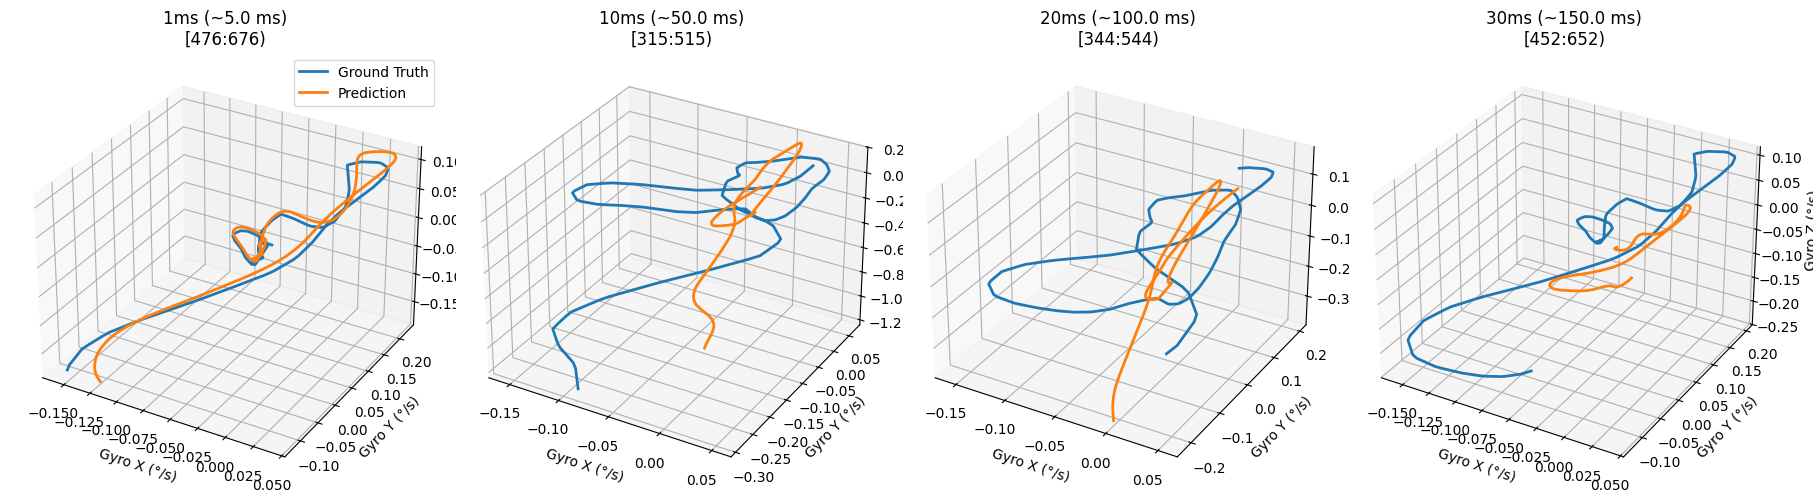

In [12]:
# Side-by-side 3D plots for all three models (raw deg/s)
import numpy as np, matplotlib.pyplot as plt, torch

MODEL_KEYS = ["1ms","10ms","20ms","30ms"]
N = 200
rng = np.random.default_rng(7)

fig = plt.figure(figsize=(18,5))

for i, key in enumerate(MODEL_KEYS, start=1):
    model = MODELS[key]
    buf = VAL_BUFFERS[key]
    X_va, y_va = buf["X_va"], buf["y_va"]
    h, target_hz = buf["h"], buf["target_hz"]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        preds = model(torch.from_numpy(X_va).float().to(device)).cpu().numpy()

    Nv = len(preds)
    start = int(rng.integers(0, max(1, Nv - N + 1)))
    end   = min(start + N, Nv)
    pred_seg  = preds[start:end]
    truth_seg = y_va[start:end]

    ax = fig.add_subplot(1,4,i, projection='3d') # Changed from 1,3,i to 1,4,i
    ax.plot(truth_seg[:,0], truth_seg[:,1], truth_seg[:,2], label="Ground Truth", linewidth=2)
    ax.plot(pred_seg[:,0],  pred_seg[:,1],  pred_seg[:,2],  label="Prediction",  linewidth=2)
    ax.set_xlabel("Gyro X (°/s)"); ax.set_ylabel("Gyro Y (°/s)"); ax.set_zlabel("Gyro Z (°/s)")
    ms = 1000.0 * h / target_hz
    ax.set_title(f"{key} (~{ms:.1f} ms)\n[{start}:{end})")
    if i == 1: ax.legend()

plt.tight_layout(); plt.show()

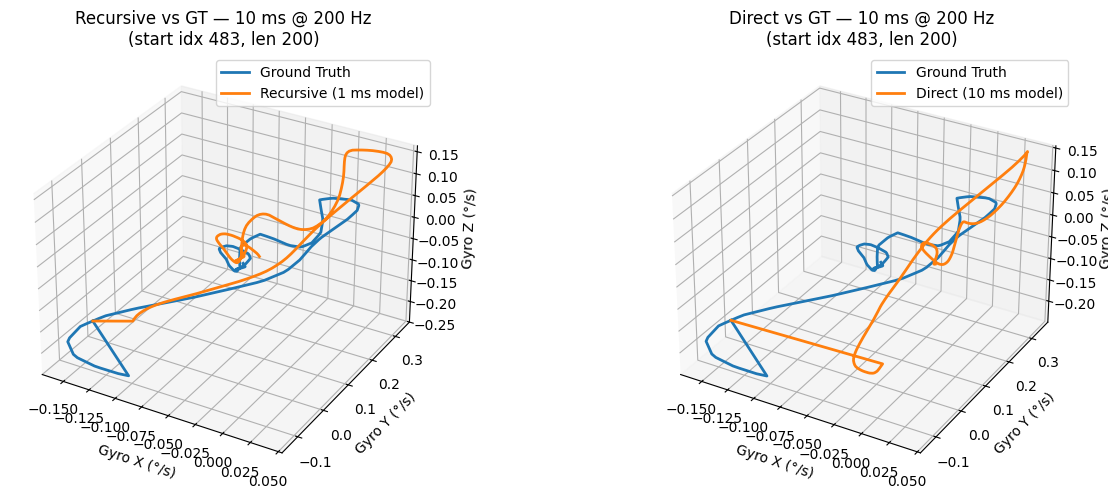

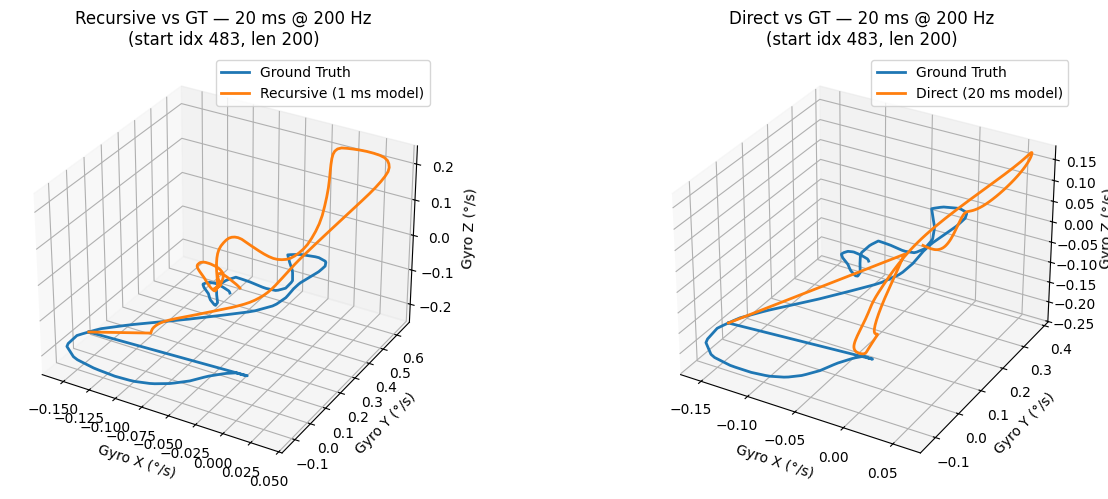

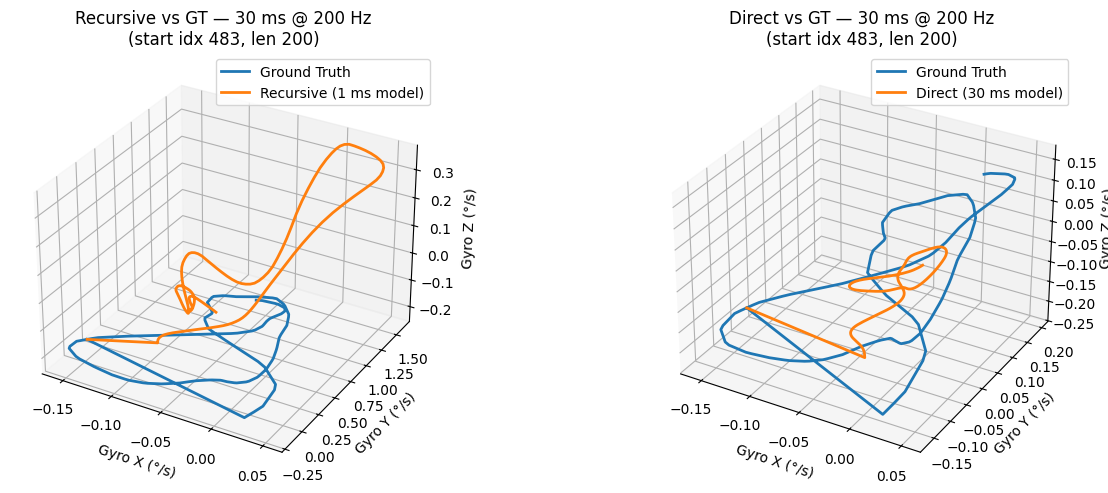

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng = np.random.default_rng(7)

HORIZONS = [10, 20, 30]   # steps at 1 kHz => ms
SEQ_LEN  = 200            # how many predictions to show per horizon

# --- base buffers for 1ms (used for recursive rollouts) ---
assert "1ms" in MODELS and "1ms" in VAL_BUFFERS, "Need a trained 1ms model and buffers."
buf1 = VAL_BUFFERS["1ms"]
X1   = buf1["X_va"]           # (N1, T1, 3)
y1   = buf1["y_va"]           # (N1, 3) -> t_end+1
T1   = buf1["T"]
hz   = buf1["target_hz"]      # expect 1000

model_1ms = MODELS["1ms"].to(device).eval()

def rollout_k_steps_1ms(model, X_start, k):
    """Roll the 1ms model forward k steps from window X_start (1, T1, 3)."""
    cur = X_start.copy()
    preds = []
    with torch.no_grad():
        for _ in range(k):
            p = model(torch.from_numpy(cur).float().to(device)).cpu().numpy()  # (1,3)
            preds.append(p[0])
            cur = np.concatenate([cur[:,1:,:], p.reshape(1,1,3)], axis=1)
    return np.array(preds, dtype=np.float32)  # (k,3)

# Pick a start index such that all mappings are valid for all horizons and for SEQ_LEN
# Mapping from 1ms window index i -> direct model k window index j = i + T1 - Tk
# Validity: 0 <= i < len(X1); 0 <= j < len(Xk)
# We enforce bounds conservatively across all k.
def find_valid_start(seq_len=SEQ_LEN):
    N1 = len(X1)
    starts = []
    for k in HORIZONS:
        key = f"{k}ms"
        assert key in VAL_BUFFERS, f"Missing buffers for {key}"
        Tk = VAL_BUFFERS[key]["T"]
        Xk = VAL_BUFFERS[key]["X_va"]
        # j = i + T1 - Tk must be in [0, len(Xk)-seq_len]
        j_min = 0
        j_max = len(Xk) - seq_len
        # i = j - (T1 - Tk)
        i_min = j_min - (T1 - Tk)
        i_max = j_max - (T1 - Tk)
        starts.append((max(0, i_min), min(N1 - seq_len, i_max)))
    i_lo = max(lo for lo, _ in starts)
    i_hi = min(hi for _, hi in starts)
    if i_lo > i_hi:
        raise ValueError("Could not find a common valid segment; reduce SEQ_LEN or horizons.")
    return int(rng.integers(i_lo, i_hi + 1))

start_idx = find_valid_start(SEQ_LEN)

for k in HORIZONS:
    key = f"{k}ms"
    bufd = VAL_BUFFERS[key]
    Xk   = bufd["X_va"]            # (Nk, Tk, 3)
    yk   = bufd["y_va"]            # (Nk, 3)
    Tk   = bufd["T"]

    # Index mapping from 1ms windows to k‑ms windows so their history ends at the same absolute time:
    # j = i + T1 - Tk
    i_indices = np.arange(start_idx, start_idx + SEQ_LEN, dtype=int)
    j_indices = i_indices + (T1 - Tk)

    # --- Ground truth sequence for k‑ms ahead (from the k‑ms buffer) ---
    gt_seq = yk[j_indices]                 # (SEQ_LEN, 3)

    # --- Direct predictions for each step (batch predict for speed) ---
    Xd_seq = Xk[j_indices]                 # (SEQ_LEN, Tk, 3)
    with torch.no_grad():
        direct_preds = (MODELS[key].to(device).eval()
                        (torch.from_numpy(Xd_seq).float().to(device))).cpu().numpy()   # (SEQ_LEN, 3)

    # --- Recursive predictions for each step (roll the 1ms model k times from each aligned 1ms window) ---
    rec_preds = np.zeros_like(direct_preds)
    for n, i in enumerate(i_indices):
        rec_preds[n] = rollout_k_steps_1ms(model_1ms, X1[i:i+1], k)[-1]  # last of the k rolled steps

    # --- Plot: left = Recursive vs GT, right = Direct vs GT ---
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    # start point (end of history) for visual continuity
    start_point = X1[start_idx, -1, :].reshape(1,3)
    gt_path  = np.concatenate([start_point, gt_seq],  axis=0)
    rec_path = np.concatenate([start_point, rec_preds], axis=0)
    dir_path = np.concatenate([start_point, direct_preds], axis=0)

    # Left: Recursive vs Ground Truth
    ax1.plot(gt_path[:,0],  gt_path[:,1],  gt_path[:,2],  label="Ground Truth", linewidth=2)
    ax1.plot(rec_path[:,0], rec_path[:,1], rec_path[:,2], label="Recursive (1 ms model)", linewidth=2)
    ax1.set_title(f"Recursive vs GT — {k} ms @ {hz} Hz\n(start idx {start_idx}, len {SEQ_LEN})")
    ax1.set_xlabel("Gyro X (°/s)"); ax1.set_ylabel("Gyro Y (°/s)"); ax1.set_zlabel("Gyro Z (°/s)")
    ax1.legend()

    # Right: Direct vs Ground Truth
    ax2.plot(gt_path[:,0],  gt_path[:,1],  gt_path[:,2],  label="Ground Truth", linewidth=2)
    ax2.plot(dir_path[:,0], dir_path[:,1], dir_path[:,2], label=f"Direct ({k} ms model)", linewidth=2)
    ax2.set_title(f"Direct vs GT — {k} ms @ {hz} Hz\n(start idx {start_idx}, len {SEQ_LEN})")
    ax2.set_xlabel("Gyro X (°/s)"); ax2.set_ylabel("Gyro Y (°/s)"); ax2.set_zlabel("Gyro Z (°/s)")
    ax2.legend()

    plt.tight_layout()
    plt.show()


In [14]:
# ---- Inference timing (single forward & recursive rollout) ----
import time
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True

def time_single_forward(model, x_np, repeats=300, warmup=50):
    """
    Time a single forward pass on input x_np (shape: (1, T, 3)).
    Returns average seconds per prediction.
    """
    x = torch.from_numpy(x_np).float().to(device)
    model = model.to(device).eval()

    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            _ = model(x)
            if device.type == "cuda":
                torch.cuda.synchronize()

        t0 = time.perf_counter()
        for _ in range(repeats):
            _ = model(x)
            if device.type == "cuda":
                torch.cuda.synchronize()
        dt = time.perf_counter() - t0

    return dt / repeats

def time_recursive_rollout_1ms(model_1ms, x_start_np, k_steps=10, repeats=100, warmup=20):
    """
    Roll the 1ms model forward k_steps autoregressively.
    Measures end-to-end time per rollout (seconds), averaged over repeats.
    """
    model = model_1ms.to(device).eval()
    x0 = torch.from_numpy(x_start_np).float().to(device)

    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            cur = x0.clone()
            for _ in range(k_steps):
                y = model(cur)
                # shift left and append y
                cur = torch.cat([cur[:, 1:, :], y.unsqueeze(1)], dim=1)
            if device.type == "cuda":
                torch.cuda.synchronize()

        t0 = time.perf_counter()
        for _ in range(repeats):
            cur = x0.clone()
            for _ in range(k_steps):
                y = model(cur)
                cur = torch.cat([cur[:, 1:, :], y.unsqueeze(1)], dim=1)
            if device.type == "cuda":
                torch.cuda.synchronize()
        dt = time.perf_counter() - t0

    return dt / repeats  # seconds per k-step rollout

def fmt_secs(s):
    return f"{s*1e3:.3f} ms  |  {1.0/s:,.0f} Hz"

# ---- Pick a representative validation window per model
def get_sample_window(model_key):
    buf = VAL_BUFFERS[model_key]
    X = buf["X_va"]
    if len(X) == 0:
        raise ValueError(f"No validation windows for {model_key}")
    return X[0:1].copy(), buf["T"], buf["target_hz"]

# ---- Time direct models
for key in ["1ms", "10ms", "20ms", "30ms"]:
    if key not in MODELS or key not in VAL_BUFFERS:
        print(f"[{key}] missing model/buffer; skipping.")
        continue
    x_sample, T, thz = get_sample_window(key)
    sec = time_single_forward(MODELS[key], x_sample)
    print(f"{key:>4} | window T={T:>4} | avg per forward: {fmt_secs(sec)}")

# ---- Time recursive rollouts with 1ms model for 10/20/30 ms
if "1ms" in MODELS and "1ms" in VAL_BUFFERS:
    x1_sample, T1, thz = get_sample_window("1ms")
    for k in (10, 20, 30):
        sec_roll = time_recursive_rollout_1ms(MODELS["1ms"], x1_sample, k_steps=k)
        print(f"1ms rollout x{k:>2} | total: {fmt_secs(sec_roll)}  (~{fmt_secs(sec_roll/k).split('|')[0].strip()} per step)")
else:
    print("1ms model/buffer not available; skipping rollout timing.")


 1ms | window T=  10 | avg per forward: 0.447 ms  |  2,237 Hz
10ms | window T=  30 | avg per forward: 0.451 ms  |  2,216 Hz
20ms | window T=  60 | avg per forward: 0.562 ms  |  1,780 Hz
30ms | window T= 150 | avg per forward: 1.307 ms  |  765 Hz
1ms rollout x10 | total: 4.680 ms  |  214 Hz  (~0.468 ms per step)
1ms rollout x20 | total: 7.572 ms  |  132 Hz  (~0.379 ms per step)
1ms rollout x30 | total: 9.021 ms  |  111 Hz  (~0.301 ms per step)


In [18]:
# -----------------------------
# Settings (time-based, not step-based)
# -----------------------------
FUT_MS = 30                 # predict 1..30 ms ahead (time-based)
HIST_STEPS = 7              # keep as "samples" of history
ANCHOR_MS = [10, 20, 30]    # anchors in milliseconds
BATCH_SIZE = 256
EPOCHS = 8
LR = 1e-3

# -----------------------------
# Utilities to align windows
# -----------------------------
assert "1ms" in MODELS and all(f"{k}ms" in MODELS for k in ANCHOR_MS), "Need 1ms and 10/20/30ms models."
buf1 = VAL_BUFFERS["1ms"]
X1, y1 = buf1["X_va"], buf1["y_va"]  # X1: (N1, T1,3), y1[n] = t_end + 1 step
T1 = buf1["T"]
hz = int(buf1["target_hz"])          # e.g., 1000, 2000, ...

def ms_to_steps(ms, hz):
    # nearest integer number of samples for a given millisecond offset
    return int(round(ms * hz / 1000.0))

# sequence length in *samples* that covers FUT_MS milliseconds
FUT_LEN = ms_to_steps(FUT_MS, hz)

# Gather direct-model buffers (same as before)
bufA = {k: VAL_BUFFERS[f"{k}ms"] for k in ANCHOR_MS}
TA = {k: bufA[k]["T"] for k in ANCHOR_MS}
XA = {k: bufA[k]["X_va"] for k in ANCHOR_MS}

# For an index i in 1ms windows, the aligned index for the k-ms window is:
# j_k = i + (T1 - Tk) so that both windows end at the same absolute time.
def aligned_index_for_k(i, k_ms):
    return i + (T1 - TA[k_ms])

# Valid i so that:
# - we can read last 7 samples from X1[i] (assumed by dataset code)
# - we can predict anchors at 10/20/30 (j_k must be in range)
# - we can collect future GT (y1[i : i + FUT_LEN])
N1 = len(X1)
i_min = 0
i_max = len(y1) - FUT_LEN  # ensure y1[i : i + FUT_LEN] is valid
for k_ms in ANCHOR_MS:
    i_min = max(i_min, - (T1 - TA[k_ms]))                        # j_k >= 0
    i_max = min(i_max, len(XA[k_ms]) - 1 - (T1 - TA[k_ms]))      # j_k <= len(Xk)-1
i_min = max(0, i_min)
i_max = min(i_max, N1 - 1)

valid_indices = np.arange(i_min, i_max + 1, dtype=int)
print(f"Valid training/eval indices: [{i_min}, {i_max}]  (count={len(valid_indices)})")

# -----------------------------
# Precompute anchors once (same logic, just iterate ANCHOR_MS)
# -----------------------------
@torch.no_grad()
def compute_anchor_preds_for_all():
    anchors = {k_ms: None for k_ms in ANCHOR_MS}  # each (N_valid, 3)
    rows = [int(i) for i in valid_indices]
    for k_ms in ANCHOR_MS:
        model_k = MODELS[f"{k_ms}ms"].to(device).eval()
        Xk_batch = XA[k_ms][[aligned_index_for_k(i, k_ms) for i in rows]]  # (N_valid, Tk, 3)
        preds = model_k(torch.from_numpy(Xk_batch).float().to(device)).cpu().numpy()  # (N_valid, 3)
        anchors[k_ms] = preds
    return anchors

anchors = compute_anchor_preds_for_all()

# (optional speedup) map index->row once to avoid np.where in __getitem__
row_of_i = {int(i): r for r, i in enumerate(valid_indices)}

# -----------------------------
# Build dataset with time-aware anchor placement
# -----------------------------
class SequenceFillDataset(Dataset):
    def __init__(self, indices):
        self.indices = np.asarray(indices, dtype=int)
        # positions (0-based) within the FUT_LEN timeline where anchors land:
        # index 0 corresponds to t+1 step, so put 10ms at ms_to_steps(10)-1, etc.
        self.pos = {ms: max(0, min(FUT_LEN - 1, ms_to_steps(ms, hz) - 1)) for ms in ANCHOR_MS}

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = int(self.indices[idx])

        # last 7 samples & velocity
        hist = X1[i, -HIST_STEPS:, :]      # (HIST_STEPS, 3)
        last = hist[-1]                    # (3,)
        vel  = hist[-1] - hist[-2] if HIST_STEPS >= 2 else np.zeros(3, dtype=np.float32)

        # build input grid (C=10, L=FUT_LEN)
        L = FUT_LEN
        inp = np.zeros((10, L), dtype=np.float32)

        # (1) anchors at t+10/20/30 ms placed at computed positions
        r = row_of_i[i]
        for c in range(3):
            for ms in ANCHOR_MS:
                inp[c, self.pos[ms]] = anchors[ms][r, c]

        # (2) anchor mask
        for ms in ANCHOR_MS:
            inp[3, self.pos[ms]] = 1.0

        # (3) last sample broadcast
        inp[4, :] = last[0]; inp[5, :] = last[1]; inp[6, :] = last[2]
        # (4) velocity broadcast
        inp[7, :] = vel[0];  inp[8, :] = vel[1];  inp[9, :] = vel[2]

        # target: future sequence of length FUT_LEN (steps), shape -> (3, L)
        tgt = y1[i : i + L]        # (L, 3)
        tgt = tgt.T                # (3, L) for Conv1d loss

        return inp, tgt

# Split indices into train/val
rng = np.random.default_rng(7)
perm = rng.permutation(valid_indices)
split = int(len(perm) * 0.8)
train_idx, val_idx = perm[:split], perm[split:]

train_ds = SequenceFillDataset(train_idx)
val_ds   = SequenceFillDataset(val_idx)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# -----------------------------
# Shallow CNN (unchanged)
# -----------------------------
class ShallowFillCNN(nn.Module):
    def __init__(self, in_ch=10, hid=32, out_ch=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, hid, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(hid, hid, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hid, out_ch, kernel_size=1)
        )

    def forward(self, x):   # x: (B, 10, L)
        return self.net(x)  # (B, 3, L)

model_cnn = ShallowFillCNN().to(device)
opt = torch.optim.AdamW(model_cnn.parameters(), lr=LR, weight_decay=1e-5)
loss_fn = nn.MSELoss()

best = float("inf")
for ep in range(1, EPOCHS+1):
    # train
    model_cnn.train()
    ...


Valid training/eval indices: [140, 697]  (count=558)


In [19]:
# ----- EVALUATE ON A CONTIGUOUS SEGMENT -----
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rng = np.random.default_rng(7)

# pick a valid index i from `valid_indices` built earlier
assert len(valid_indices) > 0, "No valid indices for CNN eval."
i = int(rng.choice(valid_indices))

# build single input for CNN (same logic as dataset __getitem__)
hist = X1[i, -HIST_STEPS:, :]                 # (7,3)
last = hist[-1]
vel  = hist[-1] - hist[-2] if HIST_STEPS >= 2 else np.zeros(3, dtype=np.float32)

pos = {10:9, 20:19, 30:29}
L = FUT_STEPS
inp_single = np.zeros((10, L), dtype=np.float32)
for c in range(3):
    for k in ANCHOR_STEPS:                    # uses precomputed `anchors`
        idx_in_valid = np.where(valid_indices == i)[0][0]
        inp_single[c, pos[k]] = anchors[k][idx_in_valid, c]
inp_single[3, pos[10]] = 1.0; inp_single[3, pos[20]] = 1.0; inp_single[3, pos[30]] = 1.0
inp_single[4, :] = last[0]; inp_single[5, :] = last[1]; inp_single[6, :] = last[2]
inp_single[7, :] = vel[0];  inp_single[8, :] = vel[1];  inp_single[9, :] = vel[2]

# ground truth future 1..30ms from 1ms buffer
gt_seq = y1[i : i + L]                        # (30,3)

# CNN prediction of full sequence
model_cnn.eval()
with torch.no_grad():
    pred_cnn = (model_cnn(torch.from_numpy(inp_single[None, ...]).float().to(device))
                .cpu().numpy()[0].transpose(1, 0))        # (30,3)

# Recursive 1ms rollout to get all 30 steps
def rollout_full_1ms(model_1ms, X_start, k):
    cur = X_start.copy()
    out = []
    with torch.no_grad():
        for _ in range(k):
            y = MODELS["1ms"].to(device).eval()(torch.from_numpy(cur).float().to(device)).cpu().numpy()  # (1,3)
            out.append(y[0])
            cur = np.concatenate([cur[:,1:,:], y.reshape(1,1,3)], axis=1)
    return np.array(out, dtype=np.float32)     # (k,3)

rec_seq = rollout_full_1ms(MODELS["1ms"], X1[i:i+1], L)    # (30,3)

# prepend the starting point (end of history) for nice trajectories
start_point = X1[i, -1, :].reshape(1,3)
gt_path  = np.concatenate([start_point, gt_seq],   axis=0)
cnn_path = np.concatenate([start_point, pred_cnn], axis=0)
rec_path = np.concatenate([start_point, rec_seq],  axis=0)

# quick metrics
def mae_rmse(a, b):
    e = a - b
    mae  = float(np.mean(np.abs(e)))
    rmse = float(np.sqrt(np.mean(e**2)))
    return mae, rmse
mae_c, rmse_c = mae_rmse(pred_cnn, gt_seq)
mae_r, rmse_r = mae_rmse(rec_seq,  gt_seq)
print(f"CNN  (1..30ms)  MAE={mae_c:.4f}  RMSE={rmse_c:.4f}  deg/s")
print(f"Recur (1ms×30)  MAE={mae_r:.4f}")


CNN  (1..30ms)  MAE=0.1427  RMSE=0.1798  deg/s
Recur (1ms×30)  MAE=0.0434


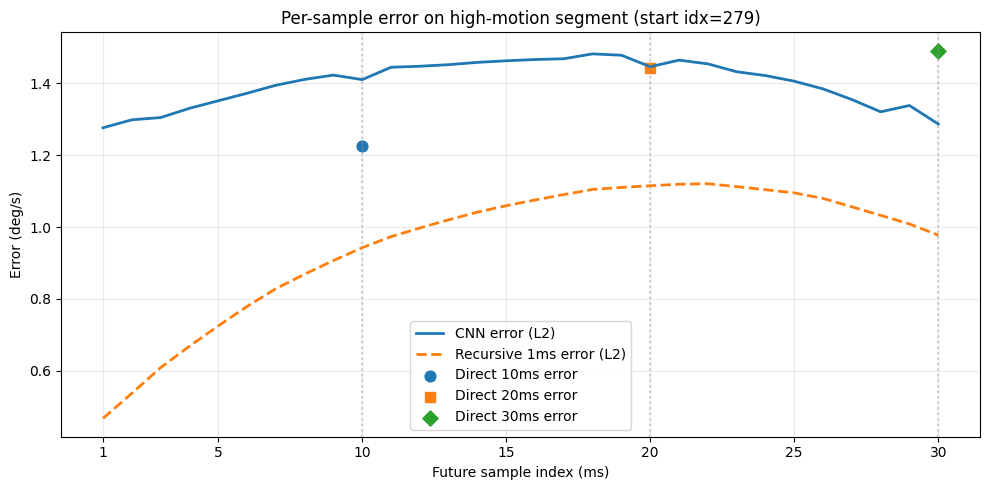

Errors at anchors (deg/s):
  CNN : 10ms=1.4107  20ms=1.4467  30ms=1.2871
  Rec : 10ms=0.9424  20ms=1.1150  30ms=0.9774
  Direct 10ms: 1.2263
  Direct 20ms: 1.4441
  Direct 30ms: 1.4913


In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# ---------- pick a high-motion segment so the plot is informative ----------
# use the 1ms buffer's GT to score motion energy over future 30 ms and choose a strong segment
buf1 = VAL_BUFFERS["1ms"]
X1, y1 = buf1["X_va"], buf1["y_va"]  # y1[n] is t_end+1 sample
hz = buf1["target_hz"]
assert len(y1) >= 30, "Need at least 30 future samples in validation."

L = 30
energies = np.array([np.linalg.norm(y1[i:i+L], axis=1).mean() for i in range(len(y1)-L)])
i_best = int(np.argmax(energies))    # strongest 30ms motion

# If you've already computed pred_cnn / rec_seq at some i, you can reuse them.
# Otherwise recompute here from i_best:
def rollout_full_1ms(model_1ms, X_start, k):
    cur = X_start.copy()
    out = []
    with torch.no_grad():
        for _ in range(k):
            y = model_1ms(torch.from_numpy(cur).float().to(device)).cpu().numpy()  # (1,3)
            out.append(y[0])
            cur = np.concatenate([cur[:,1:,:], y.reshape(1,1,3)], axis=1)
    return np.array(out, dtype=np.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ground truth future sequence (1..30 ms) from that start
gt_seq  = y1[i_best : i_best + L]                    # (30,3)
# recursive rollout (1ms model x30)
rec_seq = rollout_full_1ms(MODELS["1ms"].to(device).eval(), X1[i_best:i_best+1], L)
# CNN full-sequence prediction (rebuild the CNN input the same way you used in eval)
def build_cnn_input_from_i(i):
    hist = X1[i, -HIST_STEPS:, :]
    last = hist[-1]; vel = hist[-1] - hist[-2]
    pos = {10:9, 20:19, 30:29}
    inp = np.zeros((10, L), dtype=np.float32)
    idx_in_valid = np.where(valid_indices == i)[0]
    if len(idx_in_valid)==0:
        # fallback: use nearest valid index for anchors
        idx_in_valid = [np.argmin(np.abs(valid_indices - i))]
    idx_in_valid = int(idx_in_valid[0])
    for c in range(3):
        for k in (10,20,30):
            inp[c, pos[k]] = anchors[k][idx_in_valid, c]
    inp[3, pos[10]] = 1.0; inp[3, pos[20]] = 1.0; inp[3, pos[30]] = 1.0
    inp[4, :] = last[0]; inp[5, :] = last[1]; inp[6, :] = last[2]
    inp[7, :] = vel[0];  inp[8, :] = vel[1];  inp[9, :] = vel[2]
    return inp

model_cnn.eval()
with torch.no_grad():
    _inp = build_cnn_input_from_i(i_best)[None, ...]                # (1,10,30)
    pred_cnn = model_cnn(torch.from_numpy(_inp).float().to(device)).cpu().numpy()[0].T  # (30,3)

# ---------- errors (GT is *not* plotted as error) ----------
err_cnn = np.linalg.norm(pred_cnn - gt_seq, axis=1)   # (30,)
err_rec = np.linalg.norm(rec_seq  - gt_seq, axis=1)   # (30,)

# optional: direct model errors at 10/20/30 ms (single-step per anchor)
direct_err = {}
for k in (10,20,30):
    key = f"{k}ms"
    if key in MODELS and key in VAL_BUFFERS:
        # align the k-ms window that ends at the same time as the 1ms window end
        T1 = VAL_BUFFERS["1ms"]["T"]; Tk = VAL_BUFFERS[key]["T"]
        Xk = VAL_BUFFERS[key]["X_va"]
        j  = i_best + (T1 - Tk)
        if 0 <= j < len(Xk):
            with torch.no_grad():
                pred_k = MODELS[key].to(device).eval()(torch.from_numpy(Xk[j:j+1]).float().to(device)).cpu().numpy()[0]
            direct_err[k] = np.linalg.norm(pred_k - gt_seq[k-1])    # note: index k-1 is the kth ms (1-based)
        else:
            direct_err[k] = None
    else:
        direct_err[k] = None

# ---------- plot ----------
x = np.arange(1, L+1)

plt.figure(figsize=(10,5))
plt.plot(x, err_cnn, label="CNN error (L2)", linewidth=2)
plt.plot(x, err_rec, label="Recursive 1ms error (L2)", linewidth=2, linestyle="--")

# vertical lines at anchors
for k, col in zip((10,20,30), ["#888", "#888", "#888"]):
    plt.axvline(k, color=col, alpha=0.4, linestyle=":")

# scatter markers for direct errors at anchor steps
for k, marker in zip((10,20,30), ["o", "s", "D"]):
    if direct_err[k] is not None:
        plt.scatter([k], [direct_err[k]], s=60, marker=marker, label=f"Direct {k}ms error")

plt.xlabel("Future sample index (ms)")
plt.ylabel("Error (deg/s)")
plt.title(f"Per-sample error on high-motion segment (start idx={i_best})")
plt.xticks([1,5,10,15,20,25,30])
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# quick printout at anchors
print("Errors at anchors (deg/s):")
print(f"  CNN : 10ms={err_cnn[9]:.4f}  20ms={err_cnn[19]:.4f}  30ms={err_cnn[29]:.4f}")
print(f"  Rec : 10ms={err_rec[9]:.4f}  20ms={err_rec[19]:.4f}  30ms={err_rec[29]:.4f}")
for k in (10,20,30):
    if direct_err[k] is not None:
        print(f"  Direct {k}ms: {direct_err[k]:.4f}")


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# -------------------------
# Derive sizes & anchors
# -------------------------
# We assume train_dl/val_dl/train_ds/val_ds already exist from the previous cell.
# Use dataset's time-aware anchor positions (built from target_hz).
ANCHOR_MS = [10, 20, 30]
try:
    ANCHOR_IDXS = [train_ds.pos[ms] for ms in ANCHOR_MS]  # positions within FUT_LEN timeline
except NameError:
    # Fallback: compute from buffers if dataset objects are not in scope
    hz = int(VAL_BUFFERS["1ms"]["target_hz"])
    def ms_to_steps(ms, hz): return int(round(ms * hz / 1000.0))
    FUT_LEN = ms_to_steps(30, hz)
    ANCHOR_IDXS = [max(0, min(FUT_LEN-1, ms_to_steps(ms, hz)-1)) for ms in ANCHOR_MS]

# -------------------------
# Hyperparameters
# -------------------------
SWEEP_EPOCHS   = 16
LR             = 1e-3
WEIGHT_DECAY   = 1e-5
CLIP_NORM      = 1.0
K_LIST         = [0, 0.1, 0.5, 1, 2, 5, 10]

def seed_everything(seed=7):
    import random, os
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Make helpers agnostic to FUT_LEN (use last dim size)
def evaluate_losses(model, loader):
    """Return dict with avg L_seq, L_anchor, L_total on the loader."""
    model.eval()
    loss_seq_fn = nn.SmoothL1Loss(reduction="mean")
    tot_seq = tot_anchor = tot_total = n = 0.0
    with torch.no_grad():
        for inp, tgt in loader:
            inp = inp.to(device)        # (B,10,L)
            tgt = tgt.to(device)        # (B,3,L)
            B = inp.size(0)

            anchors_in = inp[:, 0:3, :]     # (B,3,L)
            mask       = inp[:, 3:4, :]     # (B,1,L) 1 at anchor positions

            pred = model(inp)               # (B,3,L)

            l_seq = loss_seq_fn(pred, tgt)
            denom = mask.sum().clamp_min(1e-8)
            l_anchor = F.smooth_l1_loss(pred*mask, anchors_in*mask, reduction="sum") / denom

            tot_seq   += float(l_seq.item())    * B
            tot_anchor+= float(l_anchor.item()) * B
            tot_total += float((l_seq + l_anchor).item()) * B  # k applied outside
            n += B
    n = max(1, n)
    return {
        "seq":           tot_seq / n,
        "anchor":        tot_anchor / n,
        "total_unweighted": tot_total / n
    }

def evaluate_anchor_gt_errors(model, loader, anchor_idxs):
    """Mean L2 errors at anchors vs GT."""
    model.eval()
    sums = np.zeros(len(anchor_idxs), dtype=np.float64)
    count = 0
    with torch.no_grad():
        for inp, tgt in loader:
            inp = inp.to(device)            # (B,10,L)
            tgt = tgt.to(device)            # (B,3,L)
            pred = model(inp)               # (B,3,L)
            for j, idx in enumerate(anchor_idxs):
                e = torch.linalg.norm(pred[:, :, idx] - tgt[:, :, idx], dim=1)  # (B,)
                sums[j] += e.double().sum().item()
            count += inp.size(0)
    count = max(1, count)
    return (sums / count).tolist()

# -------------------------
# Run sweep
# -------------------------
sweep_results = []

for k in K_LIST:
    seed_everything(7)

    model = ShallowFillCNN().to(device)  # must match the one defined earlier
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=SWEEP_EPOCHS)
    loss_seq_fn = nn.SmoothL1Loss(reduction="mean")

    best_val, best_state = float("inf"), None

    for ep in range(1, SWEEP_EPOCHS+1):
        # ---- train ----
        model.train()
        tr_total, n = 0.0, 0
        for inp, tgt in train_dl:
            inp = inp.to(device)     # (B,10,L)
            tgt = tgt.to(device)     # (B,3,L)
            B = inp.size(0)

            anchors_in = inp[:, 0:3, :]
            mask       = inp[:, 3:4, :]

            opt.zero_grad(set_to_none=True)
            pred = model(inp)

            l_seq    = loss_seq_fn(pred, tgt)
            denom    = mask.sum().clamp_min(1e-8)
            l_anchor = F.smooth_l1_loss(pred*mask, anchors_in*mask, reduction="sum") / denom

            loss = l_seq + k * l_anchor
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            opt.step()

            tr_total += float(loss.item()) * B
            n += B

        # ---- val ----
        model.eval()
        with torch.no_grad():
            val_parts = evaluate_losses(model, val_dl)
            val_total = val_parts["seq"] + k * val_parts["anchor"]

        sched.step()

        if val_total + 1e-9 < best_val:
            best_val = val_total
            best_state = {w: p.detach().cpu().clone() for w, p in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)

    # final metrics on val
    parts = evaluate_losses(model, val_dl)
    parts["total"] = parts["seq"] + k * parts["anchor"]
    e_list = evaluate_anchor_gt_errors(model, val_dl, ANCHOR_IDXS)

    sweep_results.append({
        "k": k,
        "val_total": parts["total"],
        "val_seq": parts["seq"],
        "val_anchor": parts["anchor"],
        "gt_errs": e_list,          # in data units
        "state_dict": best_state,
    })

for r in sweep_results:
    e10, e20, e30 = r["gt_errs"]
    print(f"k={r['k']:>5} | val_total={r['val_total']:.5f} "
          f"(seq={r['val_seq']:.5f}, anchor={r['val_anchor']:.5f}) "
          f"| GT@10/20/30 = {e10:.4f} / {e20:.4f} / {e30:.4f}")


k=    0 | val_total=0.04463 (seq=0.04463, anchor=0.04500) | GT@10/20/30 = 0.4219 / 0.3942 / 0.4215
k=  0.1 | val_total=0.04946 (seq=0.04551, anchor=0.03953) | GT@10/20/30 = 0.4176 / 0.3892 / 0.4186
k=  0.5 | val_total=0.06404 (seq=0.04944, anchor=0.02920) | GT@10/20/30 = 0.4127 / 0.3916 / 0.4192
k=    1 | val_total=0.07805 (seq=0.05265, anchor=0.02540) | GT@10/20/30 = 0.4116 / 0.3985 / 0.4243
k=    2 | val_total=0.10332 (seq=0.05584, anchor=0.02374) | GT@10/20/30 = 0.4152 / 0.4071 / 0.4321
k=    5 | val_total=0.17433 (seq=0.05852, anchor=0.02316) | GT@10/20/30 = 0.4184 / 0.4163 / 0.4400
k=   10 | val_total=0.28795 (seq=0.05958, anchor=0.02284) | GT@10/20/30 = 0.4181 / 0.4191 / 0.4430


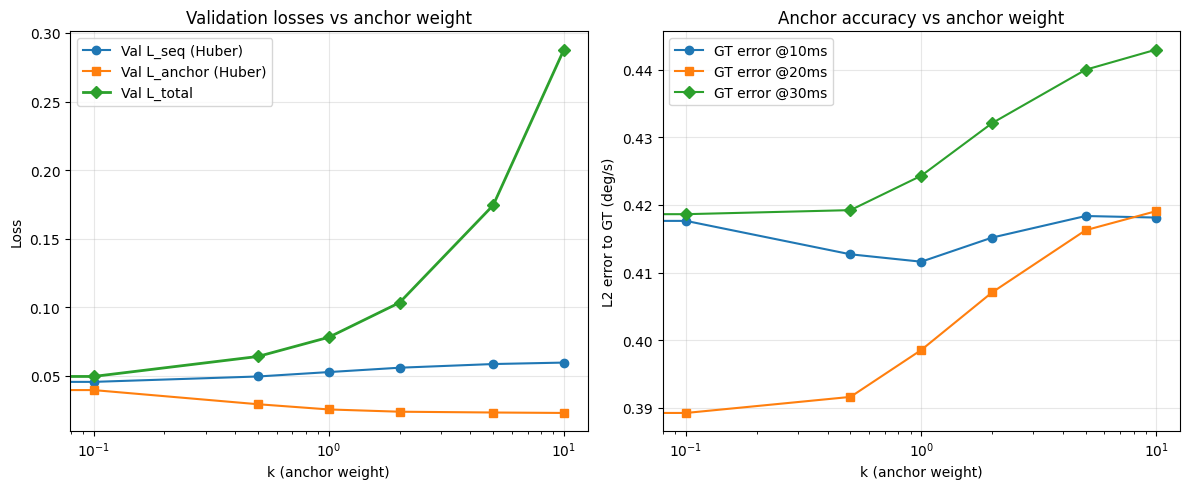

In [25]:
import matplotlib.pyplot as plt
import numpy as np

ks = np.array([r["k"] for r in sweep_results], dtype=float)
val_total  = np.array([r["val_total"]  for r in sweep_results], dtype=float)
val_seq    = np.array([r["val_seq"]    for r in sweep_results], dtype=float)
val_anchor = np.array([r["val_anchor"] for r in sweep_results], dtype=float)

# unpack GT errors (works for any anchor positions)
gt10 = np.array([r["gt_errs"][0] for r in sweep_results], dtype=float)
gt20 = np.array([r["gt_errs"][1] for r in sweep_results], dtype=float)
gt30 = np.array([r["gt_errs"][2] for r in sweep_results], dtype=float)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Loss components ---
ax = axs[0]
ax.plot(ks, val_seq,    label="Val L_seq (Huber)", marker="o")
ax.plot(ks, val_anchor, label="Val L_anchor (Huber)", marker="s")
ax.plot(ks, val_total,  label="Val L_total", marker="D", linewidth=2)
ax.set_xscale("log")
ax.set_xlabel("k (anchor weight)")
ax.set_ylabel("Loss")
ax.set_title("Validation losses vs anchor weight")
ax.grid(True, alpha=0.3)
ax.legend()

# --- GT errors at anchors ---
ax = axs[1]
ax.plot(ks, gt10, label=f"GT error @{ANCHOR_MS[0]}ms", marker="o")
ax.plot(ks, gt20, label=f"GT error @{ANCHOR_MS[1]}ms", marker="s")
ax.plot(ks, gt30, label=f"GT error @{ANCHOR_MS[2]}ms", marker="D")
ax.set_xscale("log")
ax.set_xlabel("k (anchor weight)")
ax.set_ylabel("L2 error to GT (deg/s)")
ax.set_title("Anchor accuracy vs anchor weight")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


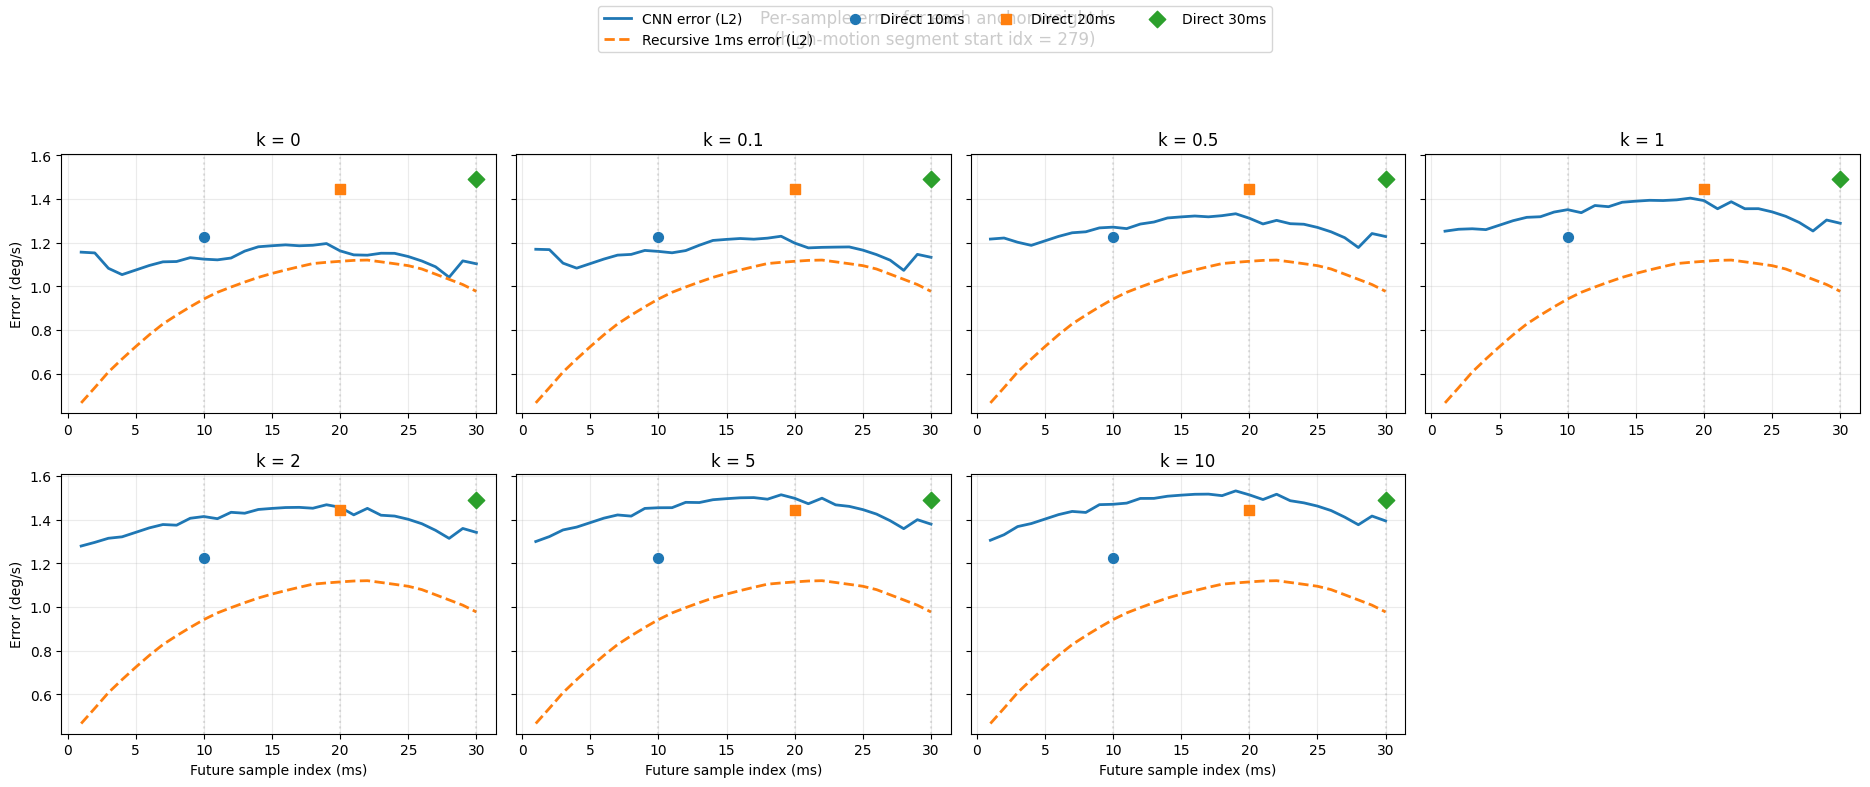

k=    0: CNN@10ms=1.1250  CNN@20ms=1.1628  CNN@30ms=1.1037
k=  0.1: CNN@10ms=1.1604  CNN@20ms=1.1984  CNN@30ms=1.1334
k=  0.5: CNN@10ms=1.2714  CNN@20ms=1.3122  CNN@30ms=1.2285
k=    1: CNN@10ms=1.3514  CNN@20ms=1.3929  CNN@30ms=1.2892
k=    2: CNN@10ms=1.4144  CNN@20ms=1.4569  CNN@30ms=1.3418
k=    5: CNN@10ms=1.4546  CNN@20ms=1.4977  CNN@30ms=1.3795
k=   10: CNN@10ms=1.4704  CNN@20ms=1.5137  CNN@30ms=1.3944


In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- CONFIG ----
L = 30                       # future length
ANCHORS = (10, 20, 30)       # ms -> indices 9,19,29
DENORM = False               # set True if y1 / preds are normalized; fill mean/std below

# If you need denorm, set vectors here (3,)
MEAN = None  # e.g., np.array([mx, my, mz], dtype=np.float32)
STD  = None  # e.g., np.array([sx, sy, sz], dtype=np.float32)

def denorm(x):
    if not DENORM: return x
    assert MEAN is not None and STD is not None
    return x * STD.reshape(1,3) + MEAN.reshape(1,3)

def rollout_full_1ms(model_1ms, X_start, k):
    cur = X_start.copy()
    out = []
    with torch.no_grad():
        for _ in range(k):
            y = model_1ms(torch.from_numpy(cur).float().to(device)).cpu().numpy()  # (1,3)
            out.append(y[0])
            cur = np.concatenate([cur[:,1:,:], y.reshape(1,1,3)], axis=1)
    return np.array(out, dtype=np.float32)  # (k,3)

def build_cnn_input_from_i(i, L=30):
    """same encoding used for training (anchors+mask+last+vel)."""
    hist = X1[i, -HIST_STEPS:, :]
    last = hist[-1]; vel = hist[-1] - hist[-2]
    pos  = {10:9, 20:19, 30:29}
    inp = np.zeros((10, L), dtype=np.float32)
    # use precomputed anchors aligned to "valid_indices"
    idx_in_valid = np.where(valid_indices == i)[0]
    if len(idx_in_valid) == 0:
        idx_in_valid = [np.argmin(np.abs(valid_indices - i))]
    idx_in_valid = int(idx_in_valid[0])
    for c in range(3):
        for k in ANCHORS:
            inp[c, pos[k]] = anchors[k][idx_in_valid, c]
    inp[3, pos[10]] = 1.0; inp[3, pos[20]] = 1.0; inp[3, pos[30]] = 1.0
    inp[4, :] = last[0]; inp[5, :] = last[1]; inp[6, :] = last[2]
    inp[7, :] = vel[0];  inp[8, :] = vel[1];  inp[9, :] = vel[2]
    return inp

# ---------- choose ONE high‑motion segment, reused for ALL k ----------
energies = np.array([np.linalg.norm(y1[i:i+L], axis=1).mean() for i in range(len(y1)-L)])
i_best = int(np.argmax(energies))

gt_seq  = denorm(y1[i_best : i_best + L])                          # (30,3)
rec_seq = denorm(rollout_full_1ms(MODELS["1ms"].to(device).eval(), X1[i_best:i_best+1], L))
err_rec = np.linalg.norm(rec_seq - gt_seq, axis=1)                 # (30,)

# Direct markers (independent of k)
direct_err = {}
T1 = VAL_BUFFERS["1ms"]["T"]
for kstep in ANCHORS:
    key = f"{kstep}ms"
    v = None
    if key in MODELS and key in VAL_BUFFERS:
        Tk = VAL_BUFFERS[key]["T"]
        Xk = VAL_BUFFERS[key]["X_va"]
        j  = i_best + (T1 - Tk)             # align end-of-window time
        if 0 <= j < len(Xk):
            with torch.no_grad():
                pk = MODELS[key].to(device).eval()(torch.from_numpy(Xk[j:j+1]).float().to(device)).cpu().numpy()[0]
            pk = denorm(pk.reshape(1,3))[0]
            v = float(np.linalg.norm(pk - gt_seq[kstep-1]))
    direct_err[kstep] = v

# ---------- assemble CNN errors per k ----------
sweep_sorted = sorted(sweep_results, key=lambda r: r["k"])
k_list = [r["k"] for r in sweep_sorted]

cnn_err_by_k = {}
for s in sweep_sorted:
    k = s["k"]
    m = ShallowFillCNN().to(device)
    m.load_state_dict(s["state_dict"])
    m.eval()
    inp = build_cnn_input_from_i(i_best)[None, ...]
    with torch.no_grad():
        pred_cnn = m(torch.from_numpy(inp).float().to(device)).cpu().numpy()[0].T  # (30,3)
    pred_cnn = denorm(pred_cnn)
    cnn_err_by_k[k] = np.linalg.norm(pred_cnn - gt_seq, axis=1)

# ---------- unified y‑limits ----------
curves = [err_rec] + [cnn_err_by_k[k] for k in k_list]
vals = np.concatenate(curves + [np.array([v for v in direct_err.values() if v is not None])])
ymin = max(0.0, float(vals.min()) * 0.9)
ymax = float(vals.max()) * 1.05

# ---------- plot grid ----------
n = len(k_list)
cols = min(4, n)
rows = int(math.ceil(n / cols))
x = np.arange(1, L+1)

fig, axes = plt.subplots(rows, cols, figsize=(4.7*cols, 3.8*rows), sharey=True)
axes = np.atleast_2d(axes)

for idx, k in enumerate(k_list):
    r = idx // cols
    c = idx % cols
    ax = axes[r, c]
    ax.plot(x, cnn_err_by_k[k], label="CNN error (L2)", linewidth=2)
    ax.plot(x, err_rec,        label="Recursive 1ms error (L2)", linewidth=2, linestyle="--")
    for vline in ANCHORS:
        ax.axvline(vline, color="#888", alpha=0.25, linestyle=":")
    if direct_err[10] is not None: ax.scatter([10],[direct_err[10]], s=50, zorder=3, label="Direct 10ms")
    if direct_err[20] is not None: ax.scatter([20],[direct_err[20]], s=60, marker="s", zorder=3, label="Direct 20ms")
    if direct_err[30] is not None: ax.scatter([30],[direct_err[30]], s=70, marker="D", zorder=3, label="Direct 30ms")

    ax.set_title(f"k = {k}")
    if r == rows-1: ax.set_xlabel("Future sample index (ms)")
    if c == 0:      ax.set_ylabel("Error (deg/s)")
    ax.set_ylim(ymin, ymax)
    ax.grid(True, alpha=0.25)

# remove unused axes (if any)
for idx in range(n, rows*cols):
    fig.delaxes(axes[idx // cols, idx % cols])

# one legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4)
plt.suptitle(f"Per-sample error for each anchor weight k\n(high-motion segment start idx = {i_best})", y=1.03)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# sanity print: CNN errors at anchors per k
for k in k_list:
    e = cnn_err_by_k[k]
    print(f"k={k:>5}: CNN@10ms={e[9]:.4f}  CNN@20ms={e[19]:.4f}  CNN@30ms={e[29]:.4f}")


In [27]:
# ---- dataset tweak: don't assume 10 exists; use min(10, T1) ----
buf1 = VAL_BUFFERS["1ms"]
X1, y1 = buf1["X_va"], buf1["y_va"]
T1 = X1.shape[1]

FUT_STEPS  = 30
HIST_STEPS = min(10, T1)   # <= important

class LastNTo30Dataset(Dataset):
    def __init__(self, indices):
        self.indices = np.asarray(indices, dtype=int)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, j):
        i = int(self.indices[j])
        hist = X1[i, -HIST_STEPS:, :]           # (N,3)
        x = np.transpose(hist, (1, 0))          # (3,N)
        y = y1[i : i + FUT_STEPS].T             # (3,30)
        return x.astype(np.float32), y.astype(np.float32)

# rebuild loaders if needed:
# ds_tr = LastNTo30Dataset(train_idx); ds_va = LastNTo30Dataset(val_idx)
# dl_tr = DataLoader(ds_tr, batch_size=256, shuffle=True,  num_workers=0)
# dl_va = DataLoader(ds_va, batch_size=256, shuffle=False, num_workers=0)


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PureCNN_LastN_to_30(nn.Module):
    """
    Input : (B, 3, N)    last N samples (N can be 7..T1)
    Output: (B, 3, 30)   next 30 samples
    """
    def __init__(self, hid=64, out_len=30):
        super().__init__()
        self.out_len = out_len
        self.backbone = nn.Sequential(
            nn.Conv1d(3, hid, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(hid, hid, kernel_size=3, padding=1, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(hid, hid, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )
        self.head = nn.Sequential(
            nn.Conv1d(hid, hid, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(hid, 3, kernel_size=1),
        )

    def forward(self, x):                 # x: (B, 3, N)
        z = self.backbone(x)              # (B, hid, N)
        # interpolate to exact out_len, regardless of N
        z = F.interpolate(z, size=self.out_len, mode="linear", align_corners=False)  # (B,hid,30)
        y = self.head(z)                  # (B, 3, 30)
        return y


In [34]:
# --- Build last-N -> future-L dataset for PureCNN_LastN_to_30 ---

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# FUT_LEN from earlier; if missing, derive from hz
try:
    FUT_LEN = FUT_LEN
except NameError:
    hz = int(VAL_BUFFERS["1ms"]["target_hz"])
    FUT_LEN = int(round(30 * hz / 1000.0))  # 30 ms horizon

# Use what's actually available in X1 (e.g., 10)
HIST_N = int(X1.shape[1])   # <- fix: was 32
print(f"Using HIST_N={HIST_N}, FUT_LEN={FUT_LEN}")

class LastNtoFutureDataset(Dataset):
    def __init__(self, indices, X_hist, y_future, hist_n=None, fut_len=None):
        self.idx = np.asarray(indices, dtype=int)
        self.X = X_hist      # (N, T_hist, 3)
        self.y = y_future    # per-step future targets; y[i:i+L] -> (L,3)
        self.hist_n = int(hist_n if hist_n is not None else X_hist.shape[1])
        self.fut_len = int(fut_len if fut_len is not None else FUT_LEN)

    def __len__(self):
        return len(self.idx)

    def __getitem__(self, k):
        i = int(self.idx[k])
        x = self.X[i, -self.hist_n:, :].astype(np.float32).T            # (3, hist_n)
        y = self.y[i : i + self.fut_len].astype(np.float32).T           # (3, fut_len)
        return torch.from_numpy(x), torch.from_numpy(y)

# Reuse existing splits if available
try:
    tr_idx, va_idx = train_idx, val_idx
except NameError:
    N = len(X1)
    valid = np.arange(0, min(N, len(y1) - FUT_LEN))
    rng = np.random.default_rng(7)
    perm = rng.permutation(valid)
    split = int(0.8 * len(perm))
    tr_idx, va_idx = perm[:split], perm[split:]

ds_tr = LastNtoFutureDataset(tr_idx, X1, y1, hist_n=HIST_N, fut_len=FUT_LEN)
ds_va = LastNtoFutureDataset(va_idx, X1, y1, hist_n=HIST_N, fut_len=FUT_LEN)

dl_tr = DataLoader(ds_tr, batch_size=256, shuffle=True, drop_last=False, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=256, shuffle=False, drop_last=False, num_workers=0)

print(f"Loaders ready: train={len(ds_tr)}, val={len(ds_va)}; x=(3,{HIST_N}), y=(3,{FUT_LEN})")


Using HIST_N=10, FUT_LEN=6
Loaders ready: train=446, val=112; x=(3,10), y=(3,6)


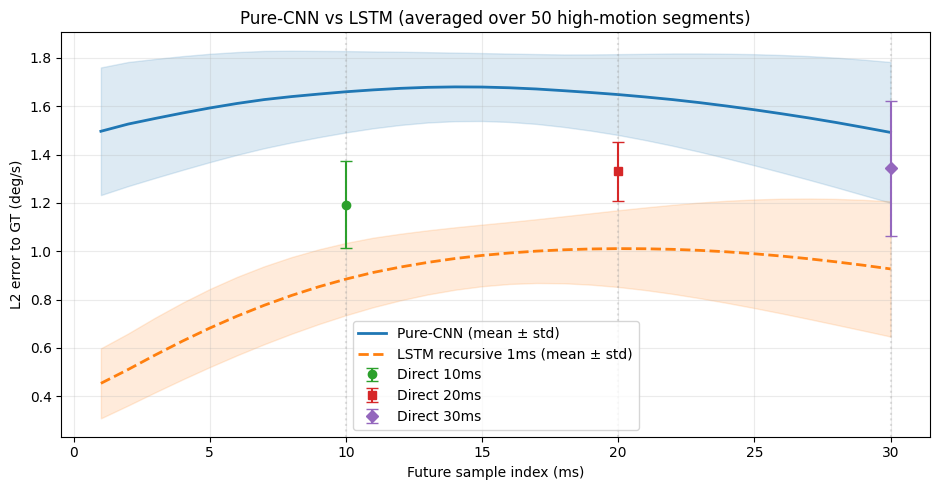

Mean L2 error (deg/s) at anchors (averaged):
  Pure‑CNN : 10ms=1.6602  20ms=1.6485  30ms=1.4920
  Rec.1ms  : 10ms=0.8849  20ms=1.0110  30ms=0.9270
  Direct   : 10ms=1.1920  20ms=1.3310  30ms=1.3438

Curve integrals (lower is better):
  Pure‑CNN AUC over 1..30ms: 48.355
  Rec.1ms  AUC over 1..30ms: 26.468


In [35]:
# ==== Pure-CNN vs LSTM (recursive 1ms + direct 10/20/30ms) ====
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- config -----
L = 30                       # future horizon (ms @ 1 kHz)
TOPK = 50                    # number of high-motion segments to average over
ANCHORS = (10, 20, 30)
DENORM = False               # set True if your X1/y1 are normalized; fill MEAN/STD below
MEAN = None                  # np.array([mx, my, mz], dtype=np.float32) if DENORM
STD  = None

def denorm(x):
    if not DENORM: return x
    return x * STD.reshape(1,3) + MEAN.reshape(1,3)

# ----- data from 1ms buffers -----
buf1 = VAL_BUFFERS["1ms"]
X1, y1 = buf1["X_va"], buf1["y_va"]     # X1: (Nv, T1, 3), y1: (Nv, 3)
T1 = X1.shape[1]

# build candidate start indices where 30 future steps exist
candidates = np.arange(0, len(y1) - L, dtype=int)
# rank by motion energy over next 30 ms
energies = np.array([np.linalg.norm(y1[i:i+L], axis=1).mean() for i in candidates])
top_idx = candidates[np.argsort(-energies)[:TOPK]]

# ----- helpers -----
def rollout_full_1ms(model_1ms, X_start, k):
    cur = X_start.copy()
    out = []
    with torch.no_grad():
        for _ in range(k):
            y = model_1ms(torch.from_numpy(cur).float().to(device)).cpu().numpy()  # (1,3)
            out.append(y[0])
            cur = np.concatenate([cur[:,1:,:], y.reshape(1,1,3)], axis=1)
    return np.array(out, dtype=np.float32)  # (k,3)

def direct_error_at_anchor(kstep, i_start):
    """L2 error of the direct kstep-ms LSTM at the single anchor point for this segment."""
    key = f"{kstep}ms"
    if key not in MODELS or key not in VAL_BUFFERS:
        return None
    Tk = VAL_BUFFERS[key]["T"]
    Xk = VAL_BUFFERS[key]["X_va"]
    # align: window ending time should match the 1ms window end
    j = i_start + (T1 - Tk)
    if not (0 <= j < len(Xk)):
        return None
    with torch.no_grad():
        pred = MODELS[key].to(device).eval()(torch.from_numpy(Xk[j:j+1]).float().to(device)).cpu().numpy()[0]  # (3,)
    pred = denorm(pred.reshape(1,3))[0]
    gt   = denorm(y1[i_start + (kstep-1)].reshape(1,3))[0]  # kth ms is index k-1
    return float(np.linalg.norm(pred - gt))

def lastN(X, i, N=10):
    N = min(N, X.shape[1])
    return X[i, -N:, :]  # (N,3)

# ----- evaluate over top-K segments -----
errs_pc = []         # per-sample L2, shape appended (30,)
errs_rec = []        # per-sample L2, shape appended (30,)
err10, err20, err30 = [], [], []

model_pc.eval()
model_1ms = MODELS["1ms"].to(device).eval()

for i in top_idx:
    # ground truth sequence
    gt_seq = denorm(y1[i:i+L])                      # (30,3)

    # pure-cnn input: last N samples -> (3,N)
    hist = lastN(X1, i, N=10)                       # (N,3)
    x_pc = np.transpose(hist, (1,0))[None, ...]     # (1,3,N)

    with torch.no_grad():
        pred_pc = model_pc(torch.from_numpy(x_pc).float().to(device)).cpu().numpy()[0].T  # (30,3)
    pred_pc = denorm(pred_pc)

    # recursive 1ms rollout
    rec_seq = denorm(rollout_full_1ms(model_1ms, X1[i:i+1], L))      # (30,3)

    # errors
    errs_pc.append(np.linalg.norm(pred_pc - gt_seq, axis=1))
    errs_rec.append(np.linalg.norm(rec_seq - gt_seq, axis=1))

    # direct anchors
    e10 = direct_error_at_anchor(10, i);
    e20 = direct_error_at_anchor(20, i);
    e30 = direct_error_at_anchor(30, i)
    if e10 is not None: err10.append(e10)
    if e20 is not None: err20.append(e20)
    if e30 is not None: err30.append(e30)

errs_pc  = np.stack(errs_pc,  axis=0)   # (K,30)
errs_rec = np.stack(errs_rec, axis=0)   # (K,30)

mean_pc,  std_pc  = errs_pc.mean(axis=0),  errs_pc.std(axis=0)
mean_rec, std_rec = errs_rec.mean(axis=0), errs_rec.std(axis=0)

mean10 = np.mean(err10) if len(err10) else None
std10  = np.std(err10)  if len(err10) else None
mean20 = np.mean(err20) if len(err20) else None
std20  = np.std(err20)  if len(err20) else None
mean30 = np.mean(err30) if len(err30) else None
std30  = np.std(err30)  if len(err30) else None

# ----- plot mean ± std -----
x = np.arange(1, L+1)
plt.figure(figsize=(9.5,5))
# CNN band
plt.fill_between(x, mean_pc-std_pc, mean_pc+std_pc, alpha=0.15, color="C0")
plt.plot(x, mean_pc, color="C0", linewidth=2, label="Pure-CNN (mean ± std)")
# Recursive band
plt.fill_between(x, mean_rec-std_rec, mean_rec+std_rec, alpha=0.15, color="C1")
plt.plot(x, mean_rec, color="C1", linewidth=2, linestyle="--", label="LSTM recursive 1ms (mean ± std)")

# vertical anchors
for v in ANCHORS:
    plt.axvline(v, color="#888", alpha=0.25, linestyle=":")

# direct markers with error bars
if mean10 is not None: plt.errorbar([10], [mean10], yerr=[std10], fmt="o",  color="C2", capsize=4, label="Direct 10ms")
if mean20 is not None: plt.errorbar([20], [mean20], yerr=[std20], fmt="s",  color="C3", capsize=4, label="Direct 20ms")
if mean30 is not None: plt.errorbar([30], [mean30], yerr=[std30], fmt="D",  color="C4", capsize=4, label="Direct 30ms")

plt.xlabel("Future sample index (ms)")
plt.ylabel("L2 error to GT (deg/s)")
plt.title(f"Pure‑CNN vs LSTM (averaged over {TOPK} high‑motion segments)")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# ----- print a quick summary -----
def area_under_curve(y):  # simple sum (discrete integral) for 30 steps
    return float(np.sum(y))

print("Mean L2 error (deg/s) at anchors (averaged):")
print(f"  Pure‑CNN : 10ms={mean_pc[9]:.4f}  20ms={mean_pc[19]:.4f}  30ms={mean_pc[29]:.4f}")
print(f"  Rec.1ms  : 10ms={mean_rec[9]:.4f}  20ms={mean_rec[19]:.4f}  30ms={mean_rec[29]:.4f}")
if mean10 is not None:
    print(f"  Direct   : 10ms={mean10:.4f}  20ms={mean20:.4f}  30ms={mean30:.4f}")

print("\nCurve integrals (lower is better):")
print(f"  Pure‑CNN AUC over 1..30ms: {area_under_curve(mean_pc):.3f}")
print(f"  Rec.1ms  AUC over 1..30ms: {area_under_curve(mean_rec):.3f}")


In [36]:
# === Latency benchmark: Pure-CNN vs LSTM (recursive 1ms & direct 10/20/30ms) ===
import time
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# ---------- data & alignment helpers ----------
buf1 = VAL_BUFFERS["1ms"]
X1 = buf1["X_va"]         # (Nv, T1, 3)
T1 = X1.shape[1]
N_HIST = min(10, T1)      # Pure-CNN history length

def align_window_for_horizon(i_1ms, horizon_key):
    """Return input window (1, Tk, 3) for the direct horizon model aligned to the same time as X1[i_1ms]."""
    Tk = VAL_BUFFERS[horizon_key]["T"]
    Xk = VAL_BUFFERS[horizon_key]["X_va"]
    j  = i_1ms + (T1 - Tk)                   # align end-of-window timestamps
    if j < 0 or j >= len(Xk):
        return None
    return Xk[j:j+1]                         # (1, Tk, 3)

def make_purecnn_input(i_1ms):
    """(1, 3, N_HIST) from last N samples of the 1ms window."""
    hist = X1[i_1ms, -N_HIST:, :]            # (N,3)
    return np.transpose(hist, (1,0))[None,...]  # (1,3,N)

# ---------- timing utils ----------
def _now():
    return time.perf_counter()

def time_op(fn, warmup=20, iters=200, sync=True):
    # warmup
    for _ in range(warmup):
        fn()
        if sync and torch.cuda.is_available():
            torch.cuda.synchronize()
    # timed
    t0 = _now()
    for _ in range(iters):
        fn()
        if sync and torch.cuda.is_available():
            torch.cuda.synchronize()
    t1 = _now()
    return (t1 - t0) * 1000.0 / iters  # ms per call

# ---------- build index set with enough future & alignment room ----------
L = 30
valid = np.arange(0, len(X1) - L, dtype=int)
rng = np.random.default_rng(7)
sampled = rng.choice(valid, size=min(300, len(valid)), replace=False)

# ----- put models on device & eval -----
pc   = model_pc.to(device).eval()
m1   = MODELS["1ms"].to(device).eval()
m10  = MODELS["10ms"].to(device).eval() if "10ms" in MODELS else None
m20  = MODELS["20ms"].to(device).eval() if "20ms" in MODELS else None
m30  = MODELS["30ms"].to(device).eval() if "30ms" in MODELS else None

# ---------- SINGLE SAMPLE LATENCY (batch=1) ----------
lat_purecnn = []
lat_rollout = []
lat_d10, lat_d20, lat_d30 = [], [], []

with torch.no_grad():
    for i in sampled:
        # Pure-CNN (one forward outputs all 30)
        x_pc = torch.from_numpy(make_purecnn_input(i)).float().to(device)  # (1,3,N)
        lat = time_op(lambda: pc(x_pc), warmup=10, iters=50)
        lat_purecnn.append(lat)

        # Recursive 1ms rollout (30 forwards of (1,T1,3) -> (1,3))
        x1 = torch.from_numpy(X1[i:i+1]).float().to(device)  # (1,T1,3)
        def step_rollout():
            cur = x1.clone()
            for _ in range(L):
                y = m1(cur)                      # (1,3)
                # shift left & append
                cur = torch.cat([cur[:,1:,:], y.view(1,1,3)], dim=1)
            return cur
        lat = time_op(step_rollout, warmup=3, iters=10)      # rollout is heavier; fewer iters
        lat_rollout.append(lat)

        # Direct 10/20/30 (single forward each)
        for key, model, collector in (("10ms", m10, lat_d10), ("20ms", m20, lat_d20), ("30ms", m30, lat_d30)):
            if model is None:
                continue
            Xk = align_window_for_horizon(i, key)
            if Xk is None:
                continue
            xk = torch.from_numpy(Xk).float().to(device)
            lat = time_op(lambda: model(xk), warmup=10, iters=50)
            collector.append(lat)

def summarize(name, arr):
    if not arr: return f"{name:<18}  n=0"
    a = np.array(arr, dtype=np.float64)
    return f"{name:<18}  {a.mean():7.3f} ms  (p50={np.median(a):.3f}, p90={np.percentile(a,90):.3f})  n={len(a)}"

print("\n=== Single‑sample inference latency (batch=1) ===")
print(summarize("Pure‑CNN (1→30)", lat_purecnn))
print(summarize("LSTM 1ms×30",     lat_rollout))
print(summarize("Direct 10ms",     lat_d10))
print(summarize("Direct 20ms",     lat_d20))
print(summarize("Direct 30ms",     lat_d30))

# ---------- BATCHED THROUGHPUT (optional) ----------
BATCH = 64
subset = sampled[:BATCH]
if len(subset) == BATCH:
    with torch.no_grad():
        # Pure-CNN batch
        xb_pc = torch.from_numpy(np.concatenate([make_purecnn_input(i) for i in subset], axis=0)).float().to(device)  # (B,3,N)
        t = time_op(lambda: pc(xb_pc), warmup=10, iters=50)
        print(f"\n=== Batched (B={BATCH}) ===")
        print(f"Pure‑CNN (B={BATCH})    {t:7.3f} ms total  |  {t/BATCH:.3f} ms / sample")

        # Recursive batch (do B independent rollouts; heavy — reduce iters)
        xb_1 = torch.from_numpy(np.concatenate([X1[i:i+1] for i in subset], axis=0)).float().to(device)  # (B,T1,3)
        def batch_roll():
            cur = xb_1.clone()
            for _ in range(L):
                y = m1(cur)                                # expected to support batch
                cur = torch.cat([cur[:,1:,:], y.view(BATCH,1,3)], dim=1)
            return cur
        t = time_op(batch_roll, warmup=2, iters=5)
        print(f"LSTM 1ms×30 (B={BATCH}) {t:7.3f} ms total  |  {t/BATCH:.3f} ms / sample")

        # Direct 10/20/30 batch (where alignment exists)
        for key, model in (("10ms", m10), ("20ms", m20), ("30ms", m30)):
            if model is None:
                continue
            Xk_list = [align_window_for_horizon(i, key) for i in subset]
            Xk_list = [x for x in Xk_list if x is not None]
            if len(Xk_list) == 0:
                continue
            xb_k = torch.from_numpy(np.concatenate(Xk_list, axis=0)).float().to(device)
            t = time_op(lambda: model(xb_k), warmup=10, iters=50)
            print(f"Direct {key:>4} (B={len(Xk_list):2d}) {t:7.3f} ms total  |  {t/len(Xk_list):.3f} ms / sample")
else:
    print("\n[Note] Skipping batched timing (not enough samples for BATCH).")



=== Single‑sample inference latency (batch=1) ===
Pure‑CNN (1→30)       0.511 ms  (p50=0.428, p90=0.681)  n=300
LSTM 1ms×30          10.997 ms  (p50=9.762, p90=13.864)  n=300
Direct 10ms           0.382 ms  (p50=0.343, p90=0.506)  n=289
Direct 20ms           0.416 ms  (p50=0.373, p90=0.544)  n=278
Direct 30ms           1.347 ms  (p50=1.259, p90=1.463)  n=242

=== Batched (B=64) ===
Pure‑CNN (B=64)      1.376 ms total  |  0.022 ms / sample
LSTM 1ms×30 (B=64)  20.050 ms total  |  0.313 ms / sample
Direct 10ms (B=61)   0.592 ms total  |  0.010 ms / sample
Direct 20ms (B=58)   0.637 ms total  |  0.011 ms / sample
Direct 30ms (B=52)   3.001 ms total  |  0.058 ms / sample


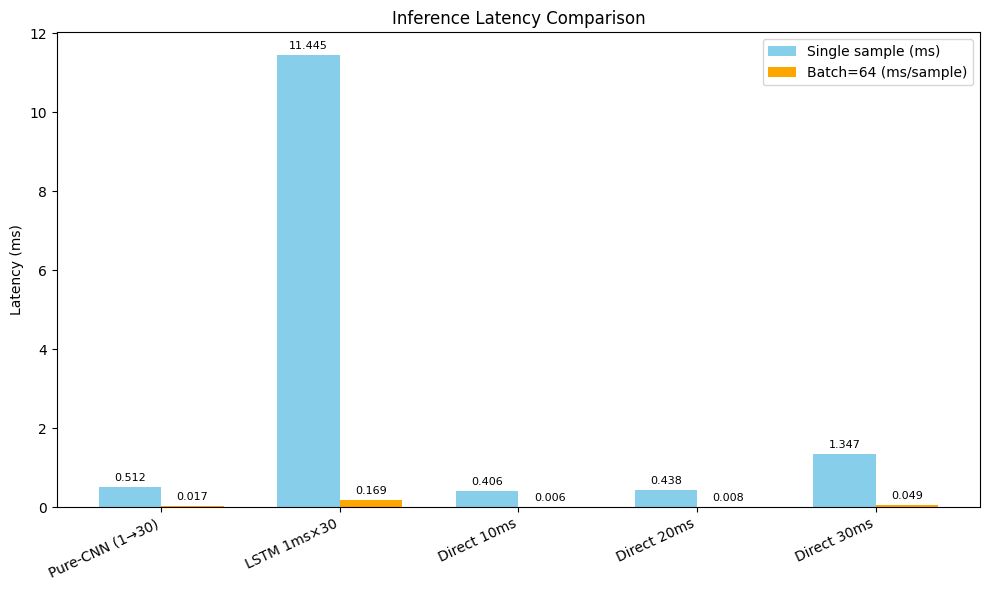

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# === Data from your results ===
methods = [
    "Pure-CNN (1→30)",
    "LSTM 1ms×30",
    "Direct 10ms",
    "Direct 20ms",
    "Direct 30ms"
]

lat_single = [0.512, 11.445, 0.406, 0.438, 1.347]  # ms
lat_batch = [0.017, 0.169, 0.006, 0.008, 0.049]    # ms/sample (B=64)

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, lat_single, width, label='Single sample (ms)', color='skyblue')
rects2 = ax.bar(x + width/2, lat_batch, width, label='Batch=64 (ms/sample)', color='orange')

# Labels and formatting
ax.set_ylabel('Latency (ms)')
ax.set_title('Inference Latency Comparison')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=25, ha='right')
ax.legend()

# Annotate bars
def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

annotate_bars(rects1)
annotate_bars(rects2)

plt.tight_layout()
plt.show()


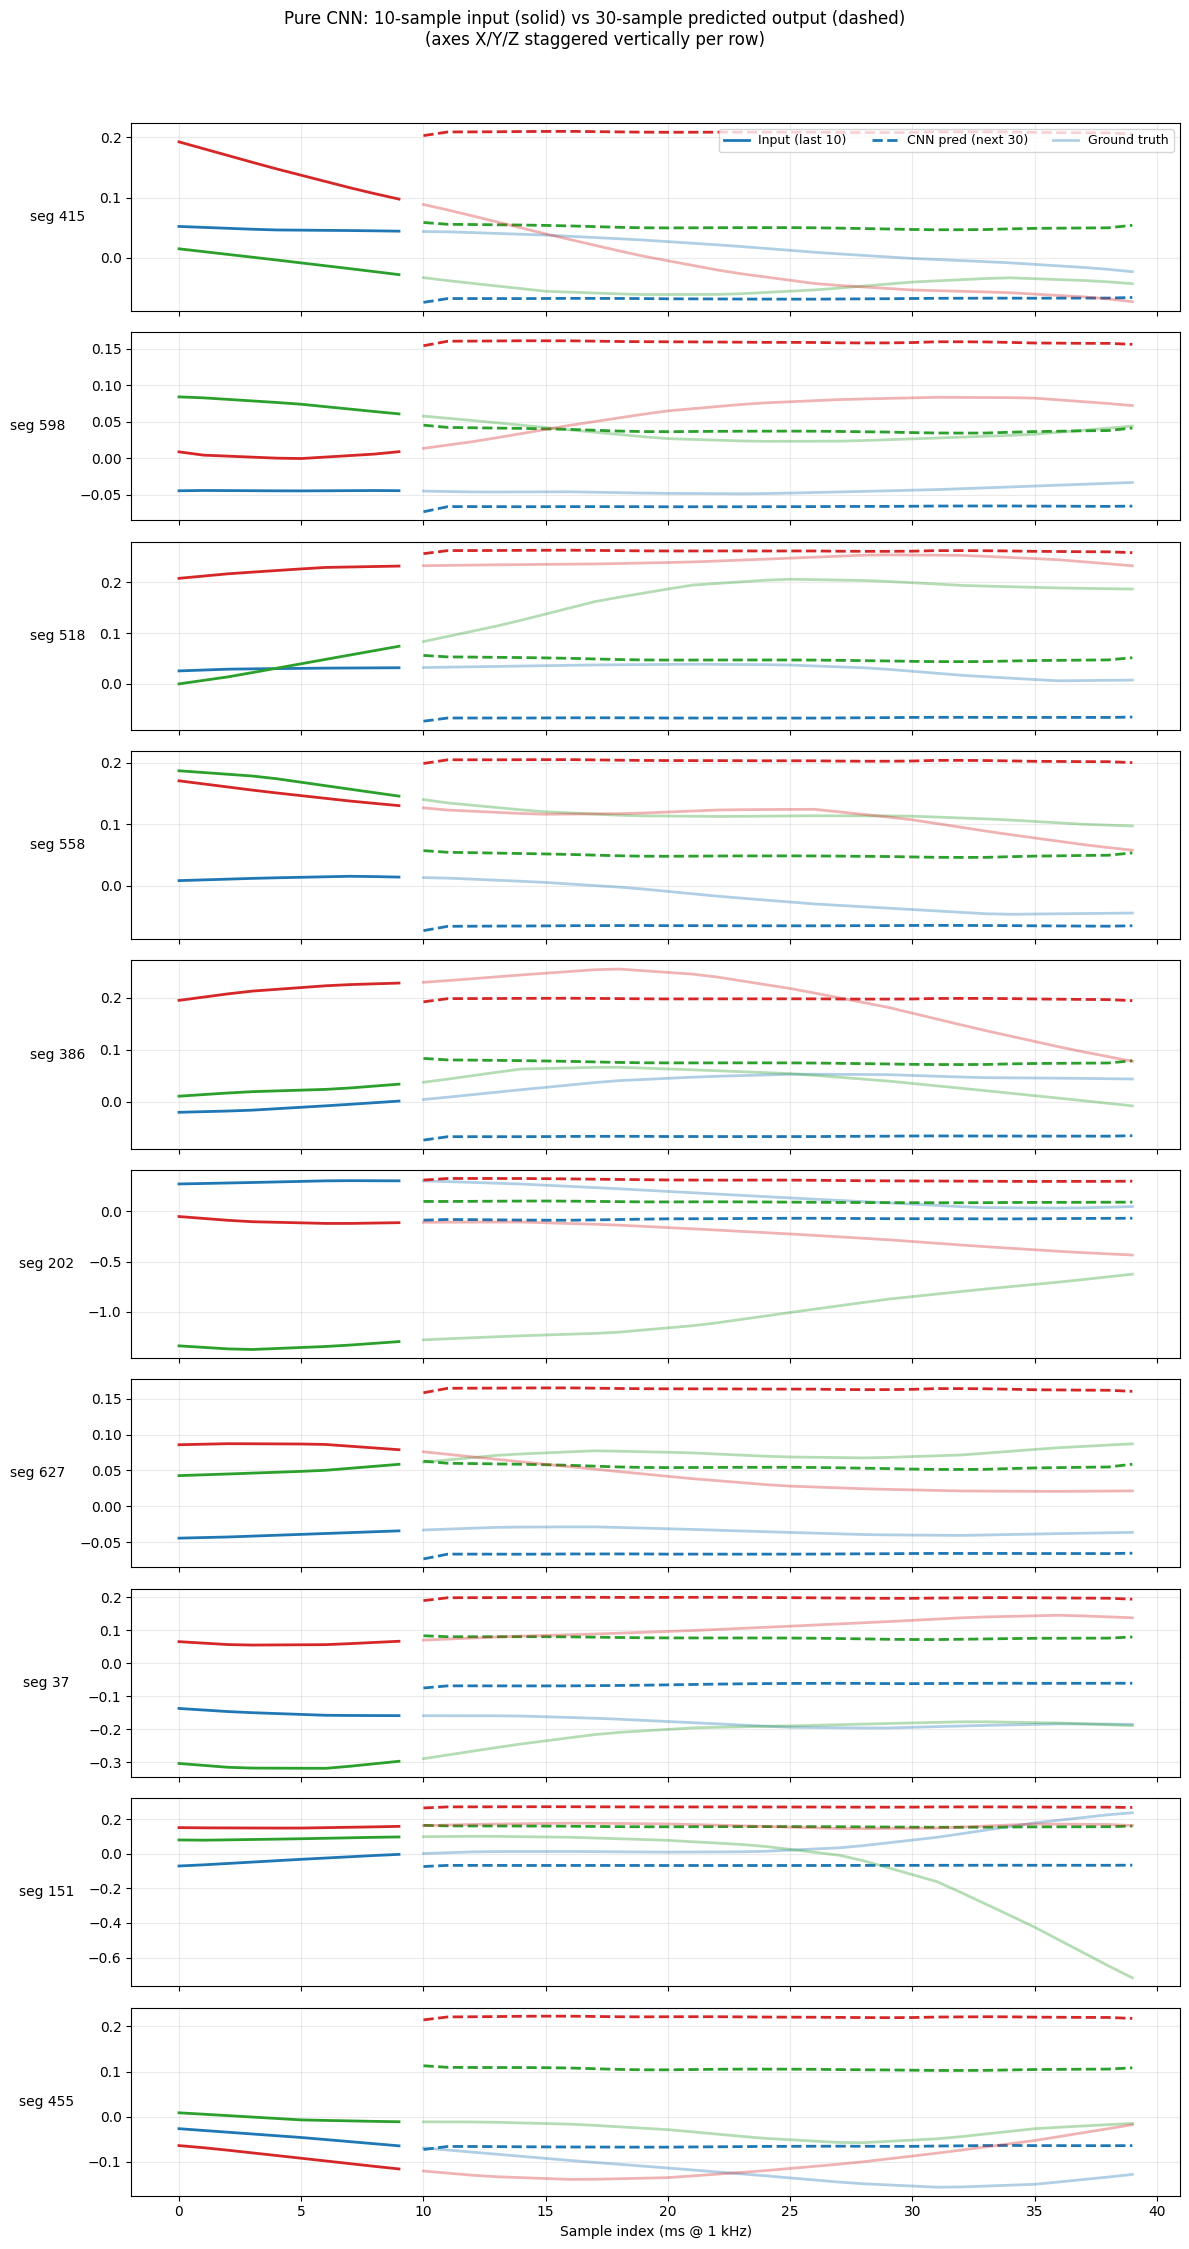

In [38]:
# --- Plot 10 segments: 10-sample input vs 30-sample CNN output (optional GT) ---

import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SHOW_GT = True   # set False if you want only input vs predicted

# 1) Grab 1ms validation buffers (assumed present)
buf1 = VAL_BUFFERS["1ms"]
X1, y1 = buf1["X_va"], buf1["y_va"]           # X1: (Nv, T1, 3), y1: (Nv, 3)
T1 = X1.shape[1]
N_HIST = min(10, T1)                          # last-10 history (or smaller if T1<10)
L_FUT  = 30                                   # predict 30 future samples

# 2) Build a list of valid start indices (need 30 future samples to exist)
valid = np.arange(0, len(y1) - L_FUT, dtype=int)
rng = np.random.default_rng(7)
sel = rng.choice(valid, size=min(10, len(valid)), replace=False)

# 3) Helper: build single CNN input from index i (shape (1, 3, N_HIST))
def make_purecnn_input(i):
    hist = X1[i, -N_HIST:, :]                 # (N_HIST, 3)
    return np.transpose(hist, (1, 0))[None, ...].astype(np.float32)  # (1,3,N_HIST)

# 4) Run model for selected segments
model_pc.eval()
preds = []     # list of (30,3)
inputs = []    # list of (10,3)
gts    = []    # list of (30,3) ground-truth future (optional)

with torch.no_grad():
    for i in sel:
        x_in = make_purecnn_input(i)
        y_hat = model_pc(torch.from_numpy(x_in).to(device)).cpu().numpy()[0].T  # (30,3)
        inputs.append(X1[i, -N_HIST:, :].copy())       # (N_HIST, 3)
        preds.append(y_hat.copy())                     # (30,3)
        if SHOW_GT:
            gts.append(y1[i:i+L_FUT].copy())          # (30,3)

# 5) Plot: one row per segment; inputs (solid) in one color; outputs (dashed) in another.
#    All three axes are plotted with small vertical offsets inside each row.
rows = len(sel)
x_in  = np.arange(N_HIST)
x_out = np.arange(N_HIST, N_HIST + L_FUT)

fig, axes = plt.subplots(rows, 1, figsize=(12, 2.2*rows), sharex=True)

if rows == 1:
    axes = [axes]

for r, i in enumerate(sel):
    ax = axes[r]
    # per-axis colors
    cols = ['C0', 'C2', 'C3']  # X, Y, Z (consistent colors)
    offset = 0.0
    for ch, c in enumerate(cols):
        # input (last 10)
        ax.plot(x_in,  inputs[r][:, ch] + offset, color=c, linewidth=2, label='Input (last 10)' if (r==0 and ch==0) else "")
        # predicted future (30)
        ax.plot(x_out, preds[r][:, ch] + offset, color=c, linestyle='--', linewidth=2, label='CNN pred (next 30)' if (r==0 and ch==0) else "")
        # optional GT overlay
        if SHOW_GT:
            ax.plot(x_out, gts[r][:, ch] + offset, color=c, alpha=0.35, linewidth=2, label='Ground truth' if (r==0 and ch==0) else "")
        # stagger channels for readability
        span = max(1e-6, np.ptp(inputs[r][:, ch]))  # protect from zero span
        offset += span * 1.8

    ax.set_ylabel(f"seg {i}", rotation=0, labelpad=30, va='center')
    ax.grid(True, alpha=0.25)

axes[-1].set_xlabel("Sample index (ms @ 1 kHz)")
axes[0].legend(loc="upper right", ncol=3, fontsize=9)
plt.suptitle("Pure CNN: 10-sample input (solid) vs 30-sample predicted output (dashed)\n(axes X/Y/Z staggered vertically per row)", y=1.02)
plt.tight_layout()
plt.show()


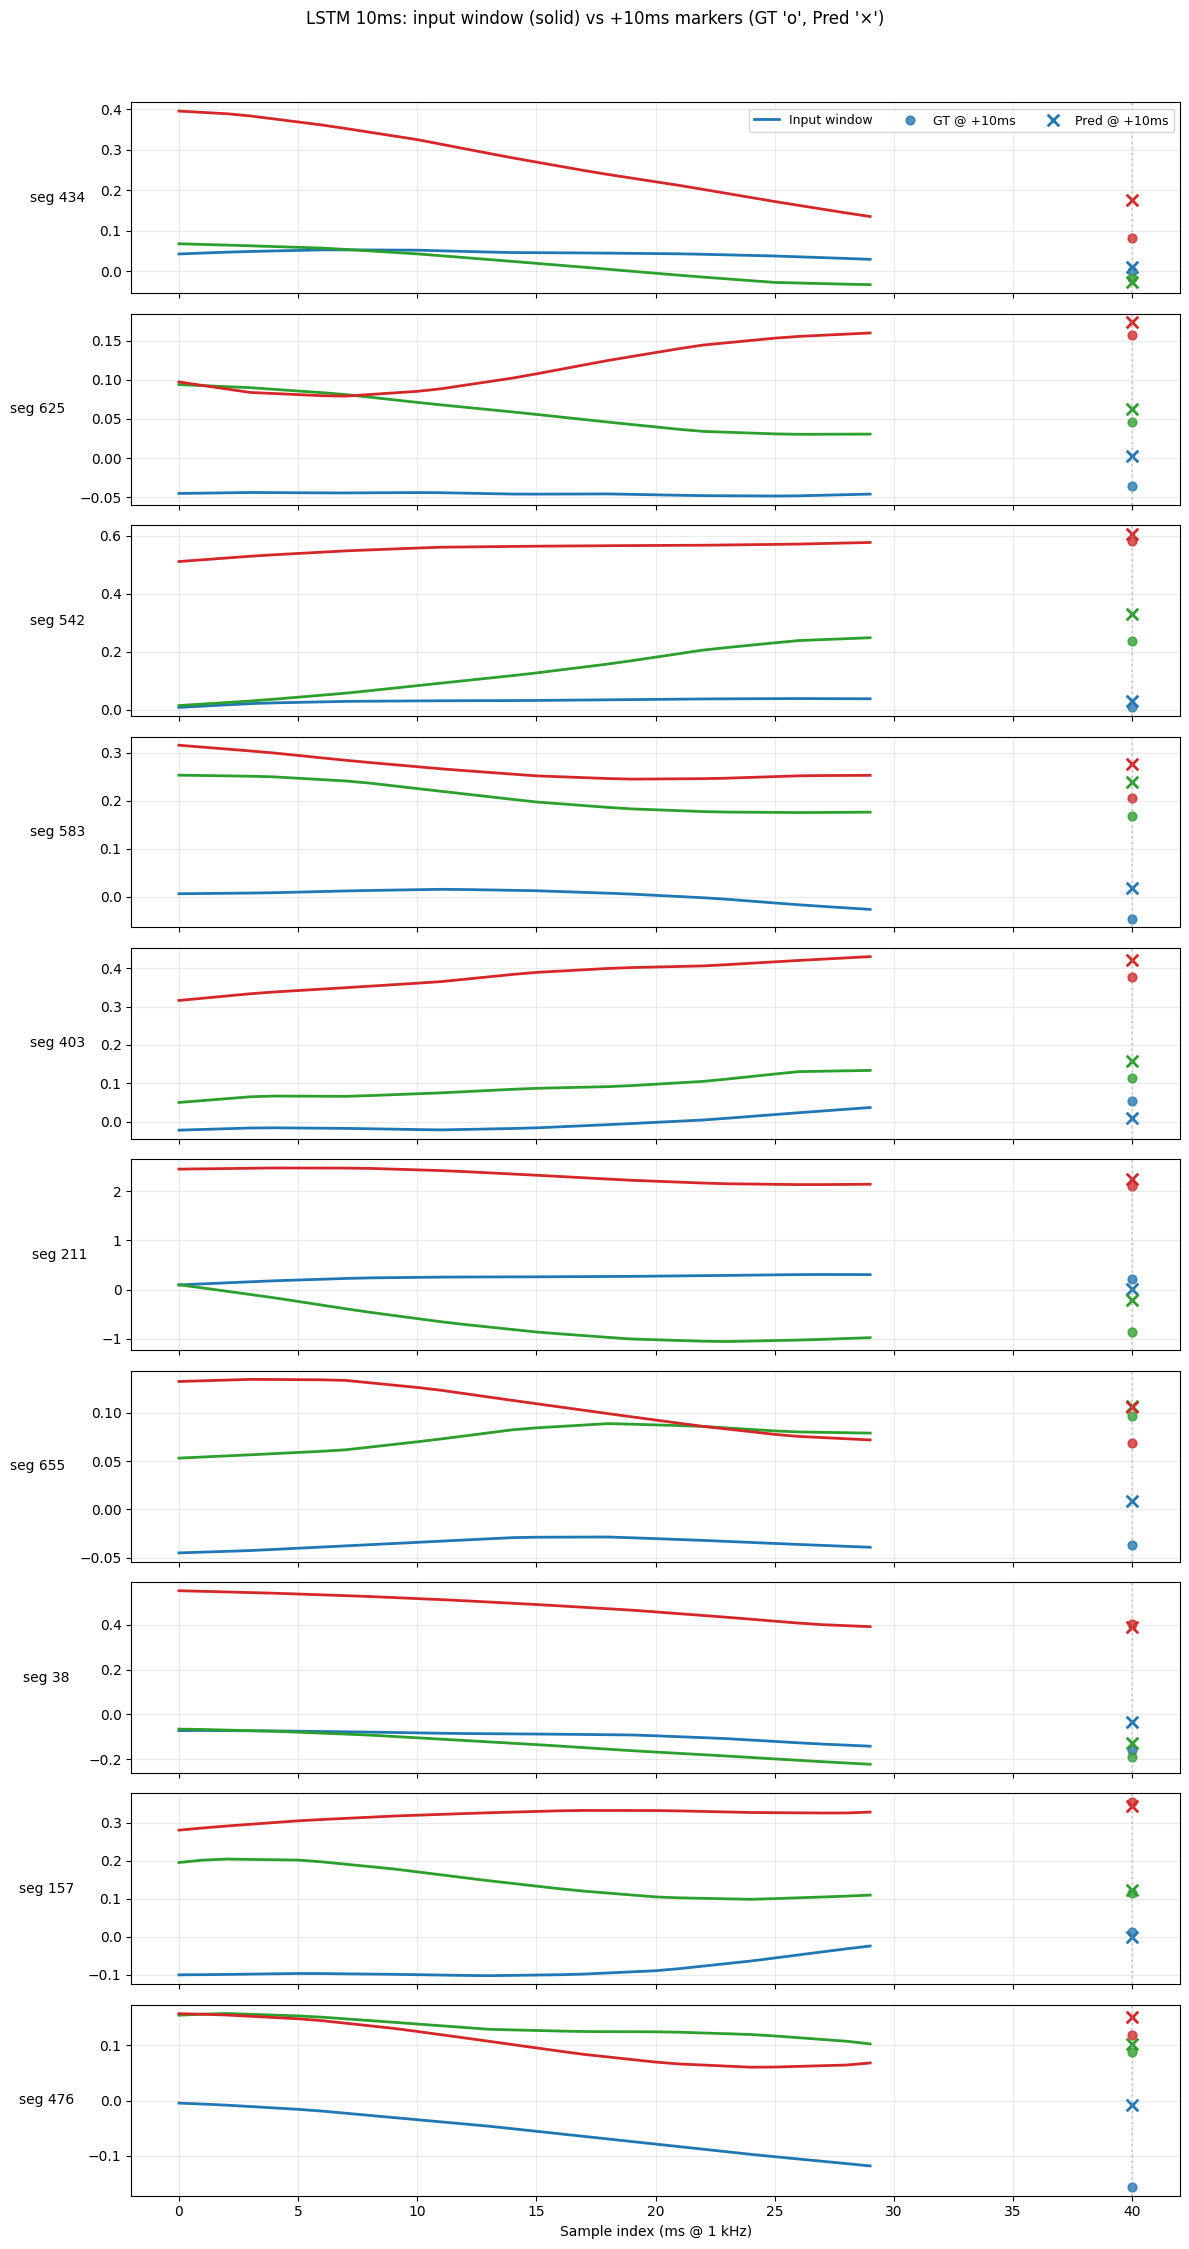

In [39]:
# --- Plot 10 segments for the 10ms LSTM: input window vs 10ms-ahead prediction (with GT) ---

import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

HKEY = "10ms"        # choose "10ms" | "20ms" | "30ms"
HORIZON_MS = 10      # matching HKEY; set to 20/30 if you switch HKEY

assert HKEY in MODELS and HKEY in VAL_BUFFERS, f"Missing buffers/models for {HKEY}"

buf  = VAL_BUFFERS[HKEY]
Xv   = buf["X_va"]                 # (Nv, T, 3)
yv   = buf["y_va"]                 # (Nv, 3) -> GT at +HORIZON_MS
T    = buf["T"]                    # input window length for this model
h    = buf["h"]                    # should equal HORIZON_MS

model = MODELS[HKEY].to(device).eval()

# pick 10 random windows
rng = np.random.default_rng(7)
Nv = len(Xv)
sel = rng.choice(np.arange(Nv), size=min(10, Nv), replace=False)

# run predictions
with torch.no_grad():
    xb = torch.from_numpy(Xv[sel]).float().to(device)       # (B,T,3)
    preds = model(xb).cpu().numpy()                         # (B,3)

# plotting
rows = len(sel)
cols = ['C0', 'C2', 'C3']   # X,Y,Z consistent colors
x_in  = np.arange(T)
x_pred = T + HORIZON_MS     # place marker at T + horizon

fig, axes = plt.subplots(rows, 1, figsize=(12, 2.2*rows), sharex=True)
if rows == 1:
    axes = [axes]

for r, idx in enumerate(sel):
    ax = axes[r]

    # stagger channels for visibility
    offset = 0.0
    for ch, c in enumerate(cols):
        series = Xv[idx, :, ch]     # (T,)
        ax.plot(x_in, series + offset, color=c, linewidth=2,
                label="Input window" if (r==0 and ch==0) else "")

        # ground-truth marker at +10 ms
        gt_val = yv[idx, ch]
        ax.scatter([x_pred], [gt_val + offset], color=c, marker='o', s=40, alpha=0.8,
                   label="GT @ +10ms" if (r==0 and ch==0) else "")

        # prediction marker at +10 ms
        pr_val = preds[r, ch]
        ax.scatter([x_pred], [pr_val + offset], color=c, marker='x', s=70, linewidths=2,
                   label="Pred @ +10ms" if (r==0 and ch==0) else "")

        # increase offset for next channel
        span = max(1e-6, np.ptp(series))
        offset += span * 1.8

    ax.set_ylabel(f"seg {idx}", rotation=0, labelpad=30, va='center')
    # vertical guide at prediction time
    ax.axvline(x_pred, color="#888", linestyle=":", alpha=0.35)
    ax.grid(True, alpha=0.25)

axes[-1].set_xlabel("Sample index (ms @ 1 kHz)")
axes[0].legend(loc="upper right", ncol=3, fontsize=9)
plt.suptitle(f"LSTM {HKEY}: input window (solid) vs +{HORIZON_MS}ms markers (GT 'o', Pred '×')", y=1.02)
plt.tight_layout()
plt.show()
